# Анализ рынка вакансий для HR Агентства

##  Цель работы :
Выявить признаки вакансий, привлекающих наибольшее внимание кандидатов и успешно закрывающихся силами агентства

Будем считать степень "привлекательности" как наибольшее число откликов и просмотров у вакансии.


**[Итоги проекта](#cell-id)**

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from urllib.parse import urlencode
import io
from scipy import stats as st
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import chi2_contingency
from math import sqrt
from wordcloud import WordCloud


In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

## Загрузка данных

In [4]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/NatCyguuYtexAg' 

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и читаем
download_response = requests.get(download_url)
df = pd.read_excel(io.BytesIO(download_response.content))


In [5]:
df.head()


,id,Статус,Источник лида,Менеджер,Дата публикации,Дата закрытия,Количество просмотров,Количество откликов,Позиция,Зарплата от,Зарплата до,Город,Формат оформления,Формат работы,Опыт,Образование,Занятость,Ссылка на тестовое,Обязательные требования,Дополнительный требования,Этапы отбора,Условия
0,40,Архив,Повторная,менеджер 9,2023-08-30,2023-08-30,153,35,Стажёр Python разработчик (неоплачиваемая стажировка для НКО),NaN,NaN,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой договор",Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Проектная, Частичная",нет,"Наш стек: Python, fastapi, postgres, gitlab\nПожелания:\n- Опыт использования одного из фреймворков/библиотек для написания сервисов на RESTful AP...","Основные требования к ребятам, которые хотели бы пройти практику в школе IT - это:\n- 8+ месяцев обучения на соответсвующем направлении\n- Один ил...",Техническое задание и интервью,Школа бесплатна и сотрудничает с фондами.\n\nСтажировка не оплачивается участникам.\n\nВ конце проекта ты сразу сможешь пополнить им своё портфоли...
1,104,Архив,Входящая заявка,менеджер 6,2023-08-22,2023-08-22,188,4,Технический интервьюер,NaN,NaN,Москва,ГПХ,Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное",Частичная,нет,"1) Широкий IT-кругозор, понимание, какие бывают языки программирования и для чего они используются.\n2) Владение хотя быть одним современным языко...",NaN,1) тестовое задание\n2) онлайн собеседование с менеджером проектов\n3) онлайн собеседование с СОО или СЕО,ставка 750 рублей - за 1 обработанного кандидата (проведено собеседование + написано заключение по нему) \nПолная удаленка\nОбучение
2,157,Архив,Реферальная,менеджер 9,2023-08-28,2023-10-03,37,8,JS-разработчик,NaN,100000.0,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой договор",Удаленка,"До 1 года опыта, возможен опыт в pet-проектах","Другое, На смежных специальностях, Профильное",Полная,нет,умение самостоятельно разбираться в чужом коде;_x000D_\nопыт самостоятельной работы над коммерческими проектами;_x000D_\nспособность к самоорганиз...,Опыт коммерческой разработки на JS будет большим преимуществом.,"- Отклик с сопроводительным письмом обязательно! Коротко рассказать о себе (навыки, заслуги, увлечения), о проектах, в которых довелось участвоват...","- Работа удаленная, оплата в форме оклада.\n- График гибкий, с удобным для Вас временем начала работы.\n- Карьерный рост с увеличением оклада.\n- ..."
3,181,Архив,Входящая заявка,NaN,2023-08-24,2023-08-24,33,7,Младший разработчик,NaN,NaN,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой договор",Офис,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","На смежных специальностях, Профильное",Полная,нет,- Высшее IT/техническое образование либо последние курсы государственного технического ВУЗа_x000D_\n- Базовое понимание физической модели данных о...,- Базовое понимание объектов БД и их применение_x000D_\n- Опыт участия в проекте разработки информационных систем_x000D_\n- Навыки владения процед...,- Скрининг резюме_x000D_\n- Техническое интервью с HR_x000D_\n- Интервью с тех. специалистом_x000D_\n- ДЗ_x000D_\n- Интервью с тимлидом/руководителем,У нас вы получите возможность:_x000D_\n- Работать с крупнейшими компаниями России и СНГ_x000D_\n- Развиваться в команде профессионалов высокого ур...
4,184,Архив,Входящая заявка,NaN,2023-08-24,2023-08-24,51,13,Младший аналитик,NaN,NaN,Москва,Трудовой договор,Офис,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","На смежных специальностях, Профильное",Полная,нет,"- ОБЯЗАТЕЛЬНО - Высшее ИТ/техническое образование,_x000D_\n- Технический английский язык_x000D_\n- Владение SQL на базовом уровне (навыки в написа...",Базовое понимание объектов БД и их применение_x000D_\nОпыт участия в проекте разработки информационных систем_x000D_\nНавыки владения процедурными...,1. Скрининг резюме_x000D_\n2. Тестовое задание_x000D_\n3. Интервью,Стабильный окла

## Оценка данных и EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1284 non-null   int64  
 1   Статус                     1284 non-null   object 
 2   Источник лида              1274 non-null   object 
 3   Менеджер                   1193 non-null   object 
 4   Дата публикации            1284 non-null   object 
 5   Дата закрытия              1127 non-null   object 
 6   Количество просмотров      1284 non-null   int64  
 7   Количество откликов        1284 non-null   int64  
 8   Позиция                    1284 non-null   object 
 9   Зарплата от                469 non-null    float64
 10  Зарплата до                372 non-null    float64
 11  Город                      1284 non-null   object 
 12  Формат оформления          1284 non-null   object 
 13  Формат работы              1284 non-null   objec

In [7]:
# создадим пустые списки
columns = [] # наименования атрибутов
type_list = [] # типы данных
null_ratio = [] # доля пропусков
unique_cnt = [] # количество уникальных значений
unique_names = [] # уникальные значения

# циклом добавим значения в пустые списки
for i in df.columns:
    columns.append(i) 
    type_list.append(df[i].dtypes)
    null_ratio.append(f'{(100 * df[i].isnull().sum()/len(df[i])):.2f}' + '%')
    unique_cnt.append(df[i].nunique())
    unique_names.append(df[i].unique())

# сохраним в датафрейм
unique_df = pd.DataFrame({'column_name' : columns,
                          'column_type' : type_list,
                          'null_ratio' : null_ratio,
                          'unique_cnt' : unique_cnt,
                          'unique_names' : unique_names})


unique_df

,column_name,column_type,null_ratio,unique_cnt,unique_names
0,id,int64,0.00%,1284,"[40, 104, 157, 181, 184, 281, 282, 283, 284, 285, 286, 287, 288, 289, 291, 293, 295, 296, 297, 298, 299, 302, 303, 304, 305, 306, 307, 308, 310, 3..."
1,Статус,object,0.00%,5,"[Архив, Закрыта нами, Отклонена, Активна, На рассмотрении]"
2,Источник лида,object,0.78%,4,"[Повторная, Входящая заявка, Реферальная, nan, Сорсинг]"
3,Менеджер,object,7.09%,9,"[менеджер 9, менеджер 6, nan, менеджер 3, менеджер 1, менеджер 2, менеджер 7, менеджер 5, менеджер 8, менеджер 4]"
4,Дата публикации,object,0.00%,250,"[2023-08-30, 2023-08-22, 2023-08-28, 2023-08-24, 2023-01-09, 2023-01-10, 2023-01-11, 2023-01-12, 2023-01-13, 2023-01-14, 2023-01-16, 2023-01-17, 2..."
5,Дата закрытия,object,12.23%,230,"[2023-08-30, 2023-08-22, 2023-10-03, 2023-08-24, 2023-01-24, 2023-03-27, 2023-03-24, 2023-06-15, 2023-03-29, 2023-04-11, 2023-03-02, 2023-03-28, 2..."
6,Количество просмотров,int64,0.00%,158,"[153, 188, 37, 33, 51, 29, 34, 46, 99, 5, 14, 18, 12, 13, 26, 10, 19, 17, 4, 21, 59, 173, 64, 44, 35, 22, 23, 2, 82, 48, 31, 15, 32, 61, 38, 43, 1..."
7,Количество откликов,int64,0.00%,64,"[35, 4, 8, 7, 13, 6, 10, 3, 2, 1, 15, 16, 9, 22, 45, 11, 14, 19, 20, 12, 23, 28, 18, 17, 29, 5, 42, 24, 38, 51, 27, 25, 30, 21, 57, 26, 32, 34, 31..."
8,Позиция,object,0.00%,684,"[Стажёр Python разработчик (неоплачиваемая стажировка для НКО), Технический интервьюер, JS-разработчик, Младший разработчик, Младший аналитик, Фро..."
9,Зарплата от,float64,63.47%,46,"[nan, 70000.0, 50000.0, 30000.0, 35000.0, 0.0, 95000.0, 80000.0, 40000.0, 60000.0, 13000.0, 10000.0, 45000.0, 44000.0, 20000.0, 500.0, 32000.0, 25..."


In [8]:
# явные дубликаты
df.duplicated().sum()

0

## Вывод по загрузке и оценке, дальнейшие действия:
- данные загрузились корректно
- явных дубликатов нет
- даты требуют изменения типа
- больше всего пропусков в столбцах с указанием зарплат (`зарплата от` - 63,47% пропусков, `зарплата до` - 71,03% пропусков. Так же 48,6% пропусков в графе `Доп. требования`
  Пропуски есть в столбцах `дата закрытия`(12,2%) и `менеджер` (7%).
- У многих показателей несколько значений в графе. Для анализа это не удобно. Будем созавать дополнительные столбцы и категории (в большинстве случаев - бинарные) что бы в дальнейшем проводить подробный анализ. Например принадлежность к городу, один ли указан город в вакансии, требуется ли высшее образование и т.п.
- по возможности данные будем упрощать, если это возможно.


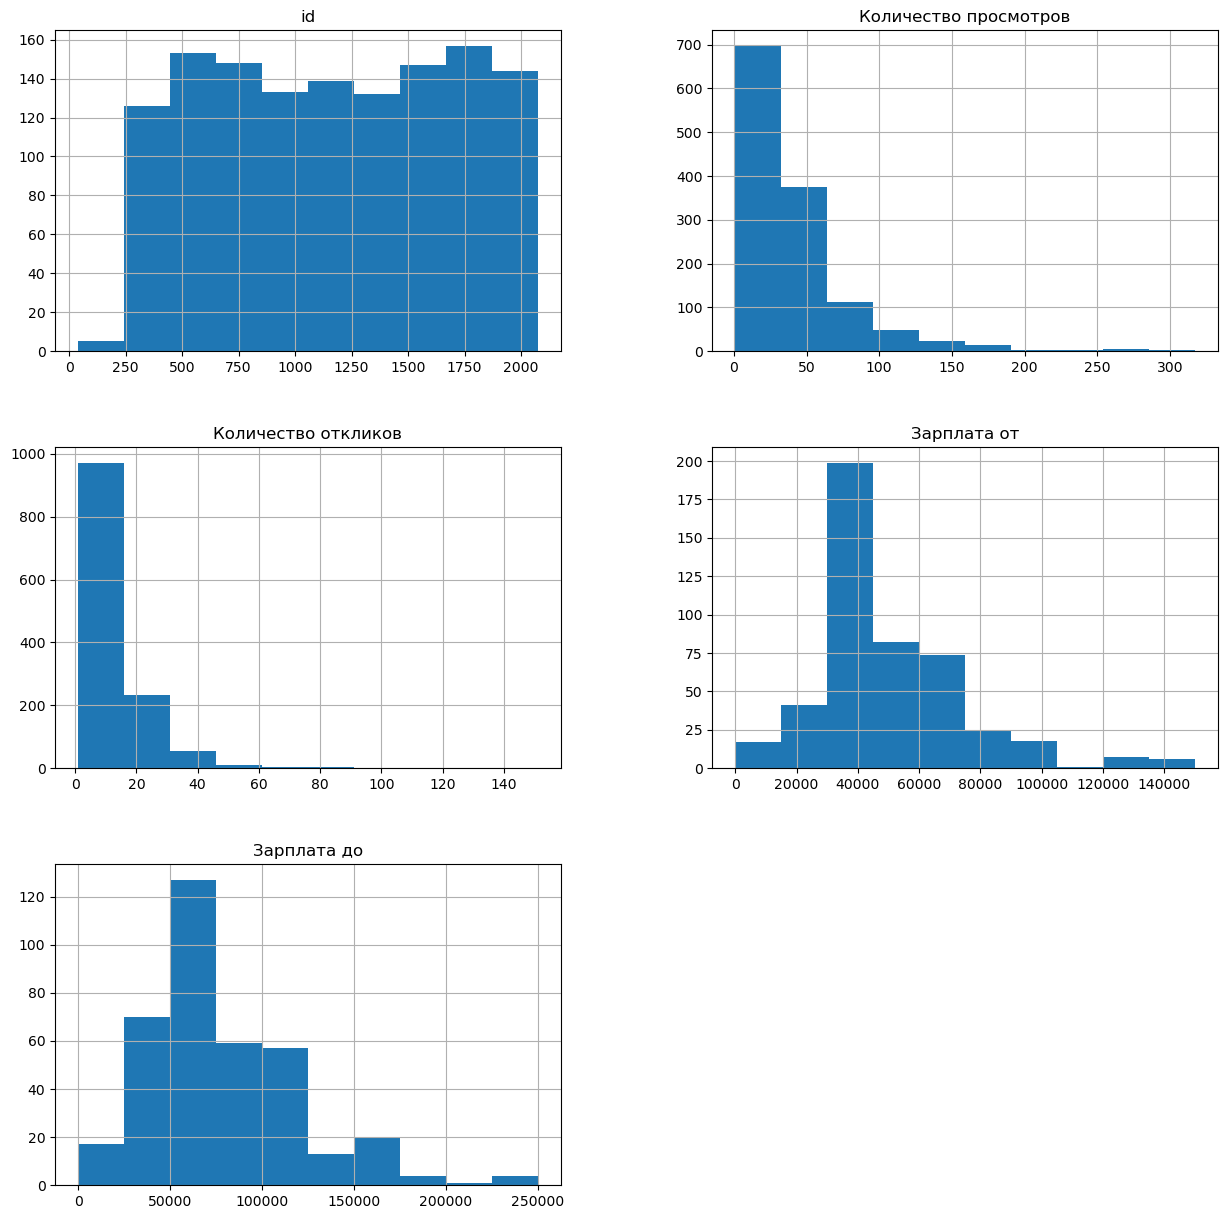

In [9]:
df.hist(figsize=(15,15));

Изменение типа датных для дат

In [10]:
df['Дата публикации'] = pd.to_datetime(df['Дата публикации'], format='%Y-%m-%d')
df['Дата закрытия'] = pd.to_datetime(df['Дата закрытия'], format='%Y-%m-%d')

### Столбец менеджер  - сокращение значений.

In [11]:
df['Менеджер'] = df['Менеджер'].str.replace('менеджер ', '')

### Количество просмотров/откликов 
Сделаем дополнительный столбец , отражающий % откликов относительно просмотров. По нему можно будет понять, насколько вакансия была интересна соискателю. 

In [12]:
df['% отклика'] = round(df['Количество откликов']/df['Количество просмотров']*100, 2)
df.insert(8, '% отклика', df.pop('% отклика'))

### Столбец Позиция, упрощение значений. Попытка сократить общее количество

In [13]:
df['Позиция'].nunique()

684

In [14]:
df['Позиция'] = df['Позиция'].str.lower()
df['Позиция'] = df['Позиция'] .str.replace('ё', 'е')

In [15]:
df['Позиция'].nunique()

656

In [16]:
df['Позиция'].unique()

array(['стажер python разработчик (неоплачиваемая стажировка для нко)',
       'технический интервьюер', 'js-разработчик', 'младший разработчик',
       'младший аналитик', 'фронтенд разработчик на проект',
       'junior project manager', 'тестировщик (ручной)',
       'project-manager', 'менеджер по контекстной рекламе',
       'python-разработчик со знанием postgresql',
       'младший интернет-маркетолог со знанием иностранного языка',
       'pr-менеджер',
       'junior account менеджер (младший менеджер digital-проектов)',
       'seo-специалист', 'специалист по data science',
       'стажер smm проектов', 'frontend/fullstack разработчик на angular',
       'junior python разработчик', 'junior аналитик данных',
       'таргетолог', 'руководитель проектов по рекламе (маркетолог)',
       'интернет-маркетолог', 'golang-разработчик',
       'frontend-разработчик', 'python-разработчик', 'project manager',
       'рекламный аналитик в директ', 'аналитик данных',
       'стажер java р

Выделим все начальные позиции в одну категорию - `junior`

Туда войдут все junior , стажеры, младшие и тп. 
Создадим список , который включает все слова, указывающие, что это начальная позиция. 

Т.к. названий вакансий очень много, сильно сократить их не удастся, поэтому создадим дополнительный столбец, который будет указывать на то, начальная это позиция или нет. Столбец будет бинарным.

In [17]:
junior = ['стажер', 'младший','junior','помощник','начинающий','джун','стажировка','ассистент']

In [18]:
df['junior'] = df['Позиция'].str.contains('|'.join(junior), na=False)
df.insert(10, 'junior', df.pop('junior'))


In [19]:
df.head(1)

,id,Статус,Источник лида,Менеджер,Дата публикации,Дата закрытия,Количество просмотров,Количество откликов,% отклика,Позиция,junior,Зарплата от,Зарплата до,Город,Формат оформления,Формат работы,Опыт,Образование,Занятость,Ссылка на тестовое,Обязательные требования,Дополнительный требования,Этапы отбора,Условия
0,40,Архив,Повторная,9,2023-08-30,2023-08-30,153,35,22.88,стажер python разработчик (неоплачиваемая стажировка для нко),True,NaN,NaN,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой договор",Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Проектная, Частичная",нет,"Наш стек: Python, fastapi, postgres, gitlab\nПожелания:\n- Опыт использования одного из фреймворков/библиотек для написания сервисов на RESTful AP...","Основные требования к ребятам, которые хотели бы пройти практику в школе IT - это:\n- 8+ месяцев обучения на соответсвующем направлении\n- Один ил...",Техническое задание и интервью,Школа бесплатна и сотрудничает с фондами.\n\nСтажировка не оплачивается участникам.\n\nВ конце проекта ты сразу сможешь пополнить им своё портфоли...


### Зарплата


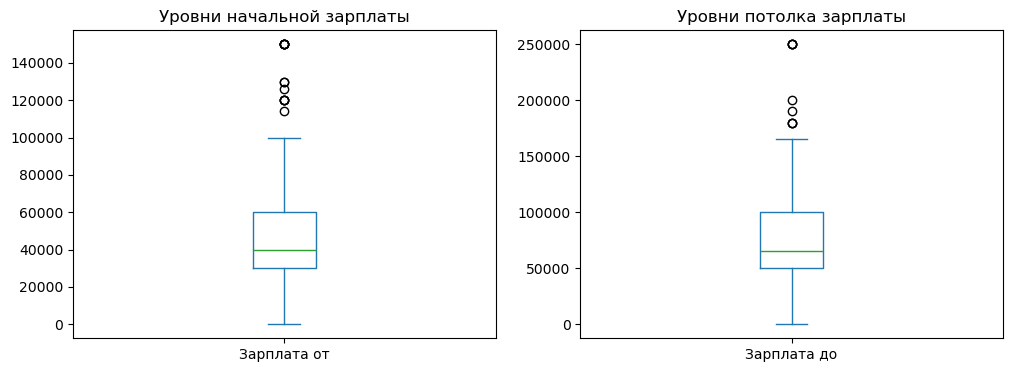

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

df['Зарплата от'].plot(kind= 'box', title='Уровни начальной зарплаты', ax=ax[0]);
df['Зарплата до'].plot(kind= 'box', title='Уровни потолка зарплаты', ax=ax[1]);


In [21]:
df[['Зарплата от', 'Зарплата до']].describe().T

,count,mean,std,min,25%,50%,75%,max
Зарплата от,469.0,47064.712154,25321.879938,0.0,30000.0,40000.0,60000.0,150000.0
Зарплата до,372.0,74808.911290,41501.835659,0.0,50000.0,65000.0,100000.0,250000.0


Посмотрим на зарплаты до 15000 (прожиточный минимум составляет 15 669 рублей рубля для трудоспособного населения России в 2023 году)

In [22]:
df[df['Зарплата до']<15000]

,id,Статус,Источник лида,Менеджер,Дата публикации,Дата закрытия,Количество просмотров,Количество откликов,% отклика,Позиция,junior,Зарплата от,Зарплата до,Город,Формат оформления,Формат работы,Опыт,Образование,Занятость,Ссылка на тестовое,Обязательные требования,Дополнительный требования,Этапы отбора,Условия
16,295,Архив,NaN,NaN,2023-01-12,2023-03-04,14,2,14.29,стажер smm проектов,True,0.0,0.0,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой договор",Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Стажировка, Проектная, Частичная",нет,"🔸базовые знания в составлении стратегии продвижения, анализе ЦА и конкурентов_x000D_\n🔸базовые знания в СММ_x000D_\n🔸грамотная устная и письменная...",NaN,"Скрининг резюме, собеседование","Длительность стажировки: 6 недель, будьте готовы тратить не менее 2-4 ч/день._x000D_\n_x000D_\nПосле стажировки мы предоставляем сертификат о прох..."
58,351,Архив,Сорсинг,NaN,2023-01-24,2023-02-02,32,8,25.00,it recruiter,False,NaN,600.0,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой договор",Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное",Полная,нет,Знание IT рынка;_x000D_\nЗнание основных каналов и инструментов поиска кандидатов;_x000D_\nНавыки проведения интервью;_x000D_\nНацеленность на рез...,Желательно: от 6 месяцев опыта работы IТ Recruiter (можем обучить),"1. Скрининг резюме (важно аккуратное оформление и мотивация - пишите сопроводительное письмо с причинами, почему вам интересно здесь работать),_x0...","График:_x000D_\nУ нас удаленная работа по графику (5/2) с 08:50 до 18:00 (GMT+3), из которого в работе 8 часов и плавающий перерыв 1 час и 10 мину..."
62,357,Архив,Повторная,3,2023-01-25,2023-08-29,61,11,18.03,ментор на направление интенсив большие данные,False,13000.0,13000.0,Москва,ГПХ,Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное",Частичная,нет,"Требования:_x000D_\n✅Питон на уровне джуна со знанием pandas и matplotlib_x000D_\n- Иметь представление о MapReduce, реляционных базах данных и SQ...",NaN,1. Скрининг резюме_x000D_\n2. Собеседование с рекрутером,Что предлагаем: за менторство одной команды из 5 учеников предлагаем 13 000 рублей в месяц._x000D_\n_x000D_\nУсловия:_x000D_\n🔸Частичная занятость...
170,499,Архив,Входящая заявка,7,2023-03-06,2023-05-02,38,10,26.32,рекрутер-сорсер (с английским),False,1200.0,1300.0,Москва,Контракт,Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Частичная, Полная",нет,"- навыки сорсинга: boolean search, X-ray;_x000D_\n- знание английского языка на уровне не ниже B1-B2;_x000D_\n- дружелюбность, организованность, с...",NaN,1. Скрининг резюме_x000D_\n2. Интервью с рекрутером_x000D_\n3. Возможно тестовое задание_x000D_\n4. Финальное интервью,"- оплата в USD или в рублях, как тебе удобно, через платежный сервис;_x000D_\n- удаленный формат работы, минимум бюрократии;_x000D_\n- здоровая ат..."
405,815,Архив,Повторная,9,2023-05-03,2023-09-22,2,1,50.00,data engineer,False,0.0,0.0,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой договор","Гибрид, Удаленка","До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное",Полная,нет,"- Высшее образование _x000D_\n-Умение работать с Clickhouse, АirFlow, Postgres, Grafana, Prometheus._x000D_\n- Технический английский язык.",Опыт от 3-х лет со схожими функциями;,1.Скрининг резюме _x000D_\n2. Общение с рекрутером. _x000D_\n3. Технические собеседование._x000D_\n4. Встреча с руководителем.,- Гибрид или удаленка_x000D_\n- Оформление в штат_x000D_\n- Фулл-тайм _x000D_\n- Зарплата обсуждается с финалистами_x000D_\n- Работа с интересными...
572,1073,Закрыта нами,Сорсинг,7,2023-06-21,2023-07-03,29,21,72.41,стажер инженер по тестированию,True,10000.0,10000.0,Москва,Контракт,"Гибрид, Удаленка","До 1 года опыта, возможен о

In [23]:
df[df['Зарплата от']<15000]

,id,Статус,Источник лида,Менеджер,Дата публикации,Дата закрытия,Количество просмотров,Количество откликов,% отклика,Позиция,junior,Зарплата от,Зарплата до,Город,Формат оформления,Формат работы,Опыт,Образование,Занятость,Ссылка на тестовое,Обязательные требования,Дополнительный требования,Этапы отбора,Условия
16,295,Архив,NaN,NaN,2023-01-12,2023-03-04,14,2,14.29,стажер smm проектов,True,0.0,0.0,Москва,"ИП, ГПХ, Самозанятость, Контракт, Трудовой договор",Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Стажировка, Проектная, Частичная",нет,"🔸базовые знания в составлении стратегии продвижения, анализе ЦА и конкурентов_x000D_\n🔸базовые знания в СММ_x000D_\n🔸грамотная устная и письменная...",NaN,"Скрининг резюме, собеседование","Длительность стажировки: 6 недель, будьте готовы тратить не менее 2-4 ч/день._x000D_\n_x000D_\nПосле стажировки мы предоставляем сертификат о прох..."
62,357,Архив,Повторная,3,2023-01-25,2023-08-29,61,11,18.03,ментор на направление интенсив большие данные,False,13000.0,13000.0,Москва,ГПХ,Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное",Частичная,нет,"Требования:_x000D_\n✅Питон на уровне джуна со знанием pandas и matplotlib_x000D_\n- Иметь представление о MapReduce, реляционных базах данных и SQ...",NaN,1. Скрининг резюме_x000D_\n2. Собеседование с рекрутером,Что предлагаем: за менторство одной команды из 5 учеников предлагаем 13 000 рублей в месяц._x000D_\n_x000D_\nУсловия:_x000D_\n🔸Частичная занятость...
79,377,Закрыта нами,Реферальная,9,2023-01-30,2023-11-08,18,8,44.44,ux/ui дизайнер,False,10000.0,20000.0,Москва,Самозанятость,Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Стажировка, Проектная",нет,"Из Hard skills:_x000D_\nFigma_x000D_\nУмение создавать прототипы, макеты_x000D_\nПонимание, как адаптировать сайт на разные платформы и устройства...",Наличие кейсов (Практикум и вне его) будет плюсом.,1. Скрининг резюме _x000D_\n2. Звонок с командой,-100% удаленка _x000D_\n-Оплачивается (+ кейс в портфолио)_x000D_\n-Рассматривают самозанятых или без оформления в штат _x000D_\n-Срок стажировки ...
133,451,Архив,Сорсинг,7,2023-02-17,2023-03-02,32,7,21.88,hr генералист,False,500.0,NaN,Бишкек,"Самозанятость, ИП","Офис, Удаленка","До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное",Полная,нет,"- коммуникабельность и отсутствие страха задавать вопросы;_x000D_\n- умение оценить план работы и время, необходимое на конкретные задачи;_x000D_\...",- опыт удаленной работы;_x000D_\n- опыт на аналогичной должности;_x000D_\n- английский B2 и выше,HR-собеседование;_x000D_\nтестовое задание;_x000D_\nвстреча с командой,"- отличные коллеги и руководители;_x000D_\n- конкурентоспособная зарплата в долларах, гибкая система вознаграждения; _x000D_\n- официальное трудоу..."
170,499,Архив,Входящая заявка,7,2023-03-06,2023-05-02,38,10,26.32,рекрутер-сорсер (с английским),False,1200.0,1300.0,Москва,Контракт,Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Частичная, Полная",нет,"- навыки сорсинга: boolean search, X-ray;_x000D_\n- знание английского языка на уровне не ниже B1-B2;_x000D_\n- дружелюбность, организованность, с...",NaN,1. Скрининг резюме_x000D_\n2. Интервью с рекрутером_x000D_\n3. Возможно тестовое задание_x000D_\n4. Финальное интервью,"- оплата в USD или в рублях, как тебе удобно, через платежный сервис;_x000D_\n- удаленный формат работы, минимум бюрократии;_x000D_\n- здоровая ат..."
338,717,Отклонена,Реферальная,9,2023-04-16,2023-05-10,34,7,20.59,интернет-маркетолог,False,10000.0,250000.0,Москва,Самозанятость,Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Проектная, Частичная",нет,Hard skills:_x000D_\n- Аналитика рынка_x000D_\n- Пос

Таких строк не много, но возможно, что зарплата указане не в рублях. Посмотрим, есть ли на это указание в условиях работы?

In [24]:
df[df['Условия'].str.contains('USD|EUR', na=False)]

,id,Статус,Источник лида,Менеджер,Дата публикации,Дата закрытия,Количество просмотров,Количество откликов,% отклика,Позиция,junior,Зарплата от,Зарплата до,Город,Формат оформления,Формат работы,Опыт,Образование,Занятость,Ссылка на тестовое,Обязательные требования,Дополнительный требования,Этапы отбора,Условия
130,445,Архив,Сорсинг,1,2023-02-16,2023-07-11,28,15,53.57,it ресечер,False,NaN,NaN,Москва,Контракт,Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Волонтерство, Проектная, Частичная, Стажировка, Полная",нет,- иметь представление об IT специальностях и пройденное обучение по направлению IT рекрутинга_x000D_\n- обладать интересом к сорсингу и желанием п...,базовое знание английского,Интервью с HRD_x000D_\nИнтервью с фаундерами,"- полностью удаленная работа_x000D_\n- ЗП в USD (перевод на любую карту)_x000D_\n- бессрочный контракт_x000D_\n- рабочий день с 10 до 19, или с 11..."
170,499,Архив,Входящая заявка,7,2023-03-06,2023-05-02,38,10,26.32,рекрутер-сорсер (с английским),False,1200.0,1300.0,Москва,Контракт,Удаленка,"До 1 года опыта, возможен опыт в pet-проектах; без опыта","Другое, На смежных специальностях, Профильное","Частичная, Полная",нет,"- навыки сорсинга: boolean search, X-ray;_x000D_\n- знание английского языка на уровне не ниже B1-B2;_x000D_\n- дружелюбность, организованность, с...",NaN,1. Скрининг резюме_x000D_\n2. Интервью с рекрутером_x000D_\n3. Возможно тестовое задание_x000D_\n4. Финальное интервью,"- оплата в USD или в рублях, как тебе удобно, через платежный сервис;_x000D_\n- удаленный формат работы, минимум бюрократии;_x000D_\n- здоровая ат..."


Таких строк только 2, в первой нет данных в зарплате, а во второй есть указание на доллар. Заменим цифру на рубли, [по курсу марта 2003](https://bankiros.ru/currency/cbrf/date/2023-03) (когда была опубликована вакансия) Он составлял 75 руб.

In [25]:
df.loc[df['id'] ==499, 'Зарплата от'] = df['Зарплата от']*75
df.loc[df['id'] ==499, 'Зарплата до'] = df['Зарплата до']*75

In [26]:
df['Зарплата от'].isnull().sum()

815

In [27]:
df['Зарплата до'].isnull().sum()

912

In [28]:
df[df['Зарплата от'].isnull()& df['Зарплата до'].isnull()][['Зарплата от', 'Зарплата до']].shape[0]

746

Строк, где оба значения пустые меньше, чем кол-во пустых значений по отдельности. Значит для создания категории можно использовать оба столбца. 

Сделаем такие категории: менее 50, 50-70, 70-100, более 100. Категории отражают суммы в тысячах рублей.

In [29]:
df['зарплата'] = pd.cut(
  df['Зарплата до'],
  bins=[0, 50000, 70000, 100000, 300000],
  labels=['<50', '50-70', '70-100', '100+']
)
df.insert(13, 'зарплата', df.pop('зарплата'))

In [30]:
df['зарплата'] = np.where(df['зарплата'].isnull(), pd.cut(
                                                          df['Зарплата от'],
                                                          bins=[0, 49000, 69000, 99000, 300000],
                                                          labels=['<50', '50-70', '70-100', '100+']
                                                        ), df['зарплата'])

In [31]:
df['зарплата'] = df['зарплата'].fillna('н/д')

Созданный столбец не содержит пропусков и будет использован для оценки зарплатных ожиданий у вакансий.

### Город. Упрощение данных

In [32]:
df['Город'].unique()

array(['Москва', 'Ростов-на-Дону', 'Санкт-Петербург', 'Челябинск',
       'Москва, Санкт-Петербург', 'Тбилиси', 'Новосибирск', 'Казань',
       'Москва, Тбилиси', 'Краснодар', 'Самара', 'Тула',
       'Москва, Ростов-на-Дону', 'Алматы, Ангарск, Москва',
       'Москва, Санкт-Петербург, Хабаровск, Иннополис, Самара',
       'Москва, Тбилиси, Санкт-Петербург', 'Алматы', 'Будва', 'Бишкек',
       'Нижний Новгород', 'Екатеринбург',
       'Калининград, Екатеринбург, Таганрог, Тверь, Казань, Тбилиси, Оренбург, Воронеж, Ульяновск, Петрозаводск, Самара',
       'Москва, Казань, Санкт-Петербург', 'Москва, Санкт-Петербург, Омск',
       'Пятигорск', 'Новороссийск, Екатеринбург, Санкт-Петербург',
       'Москва, Омск', 'Москва, Екатеринбург, Санкт-Петербург',
       'Алматы, Шымкент (Чимкент)', 'Уфа',
       'Москва, Санкт-Петербург, Новосибирск',
       'Санкт-Петербург, Волгоград, Уфа, Сургут, Екатеринбург, Москва, Ярославль, Казань, Владивосток, Иркутск, Нижний Новгород, Новосибирск, Самара, 

In [33]:
df.groupby(['Город']).agg(cnt = ('Город','count')).sort_values(by = 'cnt', ascending=False)

,cnt
Город,
Москва,870
Санкт-Петербург,137
"Москва, Санкт-Петербург",30
Казань,21
Екатеринбург,14
...,...
"Нижний Новгород, Москва, Казань, Санкт-Петербург",1
"Новороссийск, Екатеринбург, Санкт-Петербург",1
Дубаи,1


Фавориты Москва и СПб, но некоторые позиции содержат более 1 города. Интересно, влияет ли кол-во указанных городов на быстрое закрытие вакансии? или это не столь важно? 
Для дальнейшего анализа создадим 3 вспомогательных столбца: принадлежность вакансии к Москве, к СПб и бинарную категорию, если городов в вакансии более 1. 

In [34]:
# функция для добавления столбца по условию в нужное место ДФ

# new_col - название нового столбца
# new - столбец, в значениях которого проводим поиск
# str - условие для фильтрации
# т - позиция, на которую нужно вставить новый столбец


def columns_contains(df, new_col, col, str, n):
    df[new_col] =  df[col].str.contains(str, na=False)
    df.insert(n, new_col, df.pop(new_col))



In [35]:
columns_contains(df, 'Москва', 'Город', 'Москва', 15)

In [36]:
columns_contains(df, 'СПб', 'Город', 'Санкт-Петербург', 16)

In [37]:
df['Город>1'] = np.where(df['Город'].str.contains(',', na=False),True,False)
df.insert(17, 'Город>1', df.pop('Город>1'))

### Формат оформления

In [38]:
df['Формат оформления'].unique()

array(['ИП, ГПХ, Самозанятость, Контракт, Трудовой договор', 'ГПХ',
       'Трудовой договор', 'Самозанятость, ИП', 'Самозанятость, ГПХ',
       'Самозанятость', 'Самозанятость, Контракт, ИП, ГПХ',
       'Самозанятость, ИП, ГПХ', 'Контракт',
       'Самозанятость, Трудовой договор', 'Трудовой договор, ГПХ',
       'Самозанятость, Трудовой договор, ГПХ',
       'Самозанятость, ИП, Трудовой договор, ГПХ',
       'Контракт, Трудовой договор, ГПХ', 'Контракт, ГПХ',
       'Контракт, Трудовой договор', 'Самозанятость, ИП, Контракт',
       'Самозанятость, Контракт',
       'Самозанятость, Контракт, Трудовой договор',
       'Самозанятость, Контракт, ГПХ',
       'Самозанятость, ИП, Трудовой договор', 'ИП, ГПХ', 'ИП',
       'Контракт, ИП, ГПХ',
       'Самозанятость, Контракт, Трудовой договор, ГПХ',
       'ИП, Трудовой договор, ГПХ', 'ИП, Трудовой договор'], dtype=object)

Многие вакансии содежат несколько вариантов оформления. Содадим для каждого из них бинарый столбец принадлежности вакансии к нему.
Вариантов всего 5 : ИП, ГПХ, Самозанятость, Контракт, Трудовой договор

In [39]:
columns_contains(df, 'ИП', 'Формат оформления', 'ИП', 19)
columns_contains(df, 'ГПХ', 'Формат оформления', 'ГПХ', 20)
columns_contains(df, 'Сам-ть', 'Формат оформления', 'Самозанятость', 21)
columns_contains(df, 'Контракт', 'Формат оформления', 'Контракт', 22)
columns_contains(df, 'ТД', 'Формат оформления', 'Трудовой договор', 23)


### Формат работы
аналогичное преобразование

In [40]:
df['Формат работы'].unique()

array(['Удаленка', 'Офис', 'Офис, Гибрид', 'Гибрид, Удаленка',
       'Офис, Гибрид, Удаленка', 'Офис, Удаленка', 'Гибрид'], dtype=object)

In [41]:
columns_contains(df, 'Удаленка', 'Формат работы', 'Удаленка', 25)
columns_contains(df, 'Офис', 'Формат работы', 'Офис', 26)
columns_contains(df, 'Гибрид', 'Формат работы', 'Гибрид', 27)

### Опыт

In [42]:
df['Опыт'].unique()

array(['До 1 года опыта, возможен опыт в pet-проектах; без опыта',
       'До 1 года опыта, возможен опыт в pet-проектах', 'Опыт от 1 года',
       'Без опыта'], dtype=object)

In [43]:
columns_contains(df, '<1г', 'Опыт', 'До 1 года опыта', 29)
columns_contains(df, '>1г', 'Опыт', 'Опыт от 1 года', 30)
columns_contains(df, 'pet_pr', 'Опыт', 'возможен опыт в pet-проектах', 31)
columns_contains(df, 'Б/О', 'Опыт', 'Без опыта | без опыта', 32)


### Образование

In [44]:
df['Образование'].unique()

array(['Другое, На смежных специальностях, Профильное',
       'На смежных специальностях, Профильное', 'Профильное'],
      dtype=object)

In [45]:
columns_contains(df, 'другое', 'Образование', 'Другое', 34)
columns_contains(df, 'смежн', 'Образование', 'На смежных специальностях', 35)
columns_contains(df, 'проф', 'Образование', 'Профильное', 36)

### Занятость

In [46]:
df['Занятость'].unique()

array(['Проектная, Частичная', 'Частичная', 'Полная', 'Проектная',
       'Стажировка, Частичная', 'Стажировка, Проектная, Частичная',
       'Волонтерство, Проектная, Частичная, Стажировка, Полная',
       'Проектная, Частичная, Полная', 'Стажировка, Проектная',
       'Частичная, Полная', 'Проектная, Полная', 'Стажировка',
       'Стажировка, Частичная, Полная',
       'Стажировка, Волонтерство, Проектная, Частичная',
       'Стажировка, Волонтерство, Проектная',
       'Стажировка, Волонтерство, Частичная', 'Стажировка, Волонтерство',
       'Стажировка, Проектная, Частичная, Полная', 'Стажировка, Полная',
       'Стажировка, Проектная, Полная', 'Волонтерство'], dtype=object)

In [47]:
columns_contains(df, 'Проектная', 'Занятость', 'Проектная', 38)
columns_contains(df, 'Частичная', 'Занятость', 'Частичная', 39)
columns_contains(df, 'Полная', 'Занятость', 'Полная', 40)
columns_contains(df, 'Стажировка', 'Занятость', 'Стажировка', 41)
columns_contains(df, 'Волонтерство', 'Занятость', 'Волонтерство', 42)


### Обязательные  и дополнительные требования


In [48]:
df['Обязательные требования'].nunique()

1218

In [49]:
df['Дополнительный требования'].nunique()

618

Вариантов очень много. В идеале можно попытаться выделить токены и создать несколько дополнительных колонок. Но для первичного анализа хавтит выделенных категорий из других столбцов. Оставим столбцы без изменений. В обязательных требованиях пропусков нет, в дополнительных пропусков много - 48.68%

###  Этапы отбора

In [50]:
df['Этапы отбора'].unique()

array(['Техническое задание и интервью',
       '1) тестовое задание\n2) онлайн собеседование с менеджером проектов\n3) онлайн собеседование с СОО или СЕО',
       '- Отклик с сопроводительным письмом обязательно! Коротко рассказать о себе (навыки, заслуги, увлечения), о проектах, в которых довелось участвовать, о своей мотивации на компанию и задачи\n- Собеседование (обычно оно проходит в текстовом или голосовом режиме в Telegram).\n- Тестовое задание в срок, который вы сами себе установите.\n- Решение',
       '- Скрининг резюме_x000D_\n- Техническое интервью с HR_x000D_\n- Интервью с тех. специалистом_x000D_\n- ДЗ_x000D_\n- Интервью с тимлидом/руководителем',
       '1. Скрининг резюме_x000D_\n2. Тестовое задание_x000D_\n3.   Интервью',
       '1. Скрининг портфолио_x000D_\n2. Собеседование с руководителем направления и hr-менеджером',
       '1. Скрининг резюме (важно аккуратное оформление и мотивация - пишите сопроводительное письмо с причинами, почему вам интересно здесь работать

In [51]:
df['Этапы отбора'] = df['Этапы отбора'].replace('_x000D_\n', ' ', regex=True)

In [52]:
df['Этапы отбора'].unique()

array(['Техническое задание и интервью',
       '1) тестовое задание\n2) онлайн собеседование с менеджером проектов\n3) онлайн собеседование с СОО или СЕО',
       '- Отклик с сопроводительным письмом обязательно! Коротко рассказать о себе (навыки, заслуги, увлечения), о проектах, в которых довелось участвовать, о своей мотивации на компанию и задачи\n- Собеседование (обычно оно проходит в текстовом или голосовом режиме в Telegram).\n- Тестовое задание в срок, который вы сами себе установите.\n- Решение',
       '- Скрининг резюме - Техническое интервью с HR - Интервью с тех. специалистом - ДЗ - Интервью с тимлидом/руководителем',
       '1. Скрининг резюме 2. Тестовое задание 3.   Интервью',
       '1. Скрининг портфолио 2. Собеседование с руководителем направления и hr-менеджером',
       '1. Скрининг резюме (важно аккуратное оформление и мотивация - пишите сопроводительное письмо с причинами, почему вам интересно здесь работать), 2. Заполнение анкеты с вопросами на логику 3. Интервь

In [53]:
df['Этапы отбора'].nunique()

839

Уникальных значений в этапах отбора много - 839. Поэтому выделить простую последовательность например : `резюме -> созвон -> тестовое -> собеседование` сложно.
Сам столбец оставим без изменений. Проверим такую гипотезу: если в этапах отбора присутствует тестовое, оно доступно для соискателя сразу? 

Наличие тестового отражает столбец 'ссылка на тестовое', и там нет пропусков. Создадим бинарый столбец, который будет отражать, встречается ли в этапах отбора тестовое задание?

In [54]:
df['Этап тест'] = df['Этапы отбора'].str.contains('Тест|тест', na=False)
df.insert(47, 'Этап тест', df.pop('Этап тест'))

In [55]:
df_test = df.groupby(['Этап тест', 'Ссылка на тестовое'] ).agg(cnt = ('Этап тест', 'count')).reset_index()
df_test['%cnt'] = np.where(df_test['Этап тест'], round(df_test['cnt']/(df[df['Этап тест']].shape[0])*100,2), round(df_test['cnt']/(df[~df['Этап тест']].shape[0])*100,2))
df_test

,Этап тест,Ссылка на тестовое,cnt,%cnt
0,False,да,7,1.11
1,False,нет,626,98.89
2,True,да,99,15.21
3,True,нет,552,84.79


Если в этапах отбора тестовое задание явно не заявлено, то ссылка на него указана в 1% и в 99 % ее нет. Этот вариант логичен. 
Если в этапах отбора присутствует тестовое задание, то ссылка на него сразу указывается только в 15% объявлений, а в 85% ссылка на тестовое сразу не указывается. 

А вот эта группа интересна. При дальнейшем анализе проверим, влияет ли выложенная сразу ссылка на тестовое задание на успешность закрытия вакансии?

### Условия

In [56]:
df['Условия'].unique()

array(['Школа бесплатна и сотрудничает с фондами.\n\nСтажировка не оплачивается участникам.\n\nВ конце проекта ты сразу сможешь пополнить им своё портфолио. Проект будет реализован людьми для людей.',
       'ставка 750 рублей - за 1 обработанного кандидата (проведено собеседование + написано заключение по нему) \nПолная удаленка\nОбучение',
       '- Работа удаленная, оплата в форме оклада.\n- График гибкий, с удобным для Вас временем начала работы.\n- Карьерный рост с увеличением оклада.\n- Испытательный срок — 2 месяца.\n- Доступно соискателям с инвалидностью.',
       ...,
       'Удаленка, но можно приходить в офис Яндекса периодически в качестве гостя_x000D_\n_x000D_\nВне штата _x000D_\nОплата также обсуждается индивидуально _x000D_\n_x000D_\nПроект с реальной возможностью курировать проект далее. _x000D_\n_x000D_\nСейчас основной контакт - заказчик _x000D_\n(готов драйвить проект как продакт). Соответственно, мы возьмем на себя часть, связанную с контентом - подготовкой сценария

In [57]:
df['Условия'].nunique()

1167

Вариантов условий работы много - 1167. Единого образца нет. Вариантов упрощения и сокращения нет. Оставим столбец как есть. 

## Итоги предобработки:

- сделаны дополнительные бинарные столбцы, которые позволят учитывать при анализе отдельные категории в образовании, формате оформления, формате работы, опыте, занятости
- созданы категории в зарплатах
- главные города Москва и Санк-Петербург выдеделены отдельно. Так же помечены вакансии, где указано более 1 города в вакансии
- введен параметр % отклика, который отражает отношение кол-ва откликов к кол-ву просмотров. Параметр отражает "привлекательность" вакансии. Чем он больше, тем большее количество просмотревших людей откликнулось на вакансию.
- выделена позиция junior  в вакансиях.
- посчитан % вакансий, в которых заявлено в требованиях тестовое задание, но ссылка на него указана сразу и тех, где ссылка сразу не указана.


Добавим столбец с кол-вом дней от даты публикации до закрытия вакансии. 

Кол-во дней  имеeт смысл считать только для тех вакансий, у которых есть дата закрытия. Для тех у кого такой даты нет (не закрыта на момент обзора) значение оставим пустым.

In [58]:
df['diff'] = (df['Дата закрытия'] - df['Дата публикации']).dt.days
df.insert(6, 'diff', df.pop('diff'))

# Анализ "успешности вакансии"

## Воронка закрытия вакансии

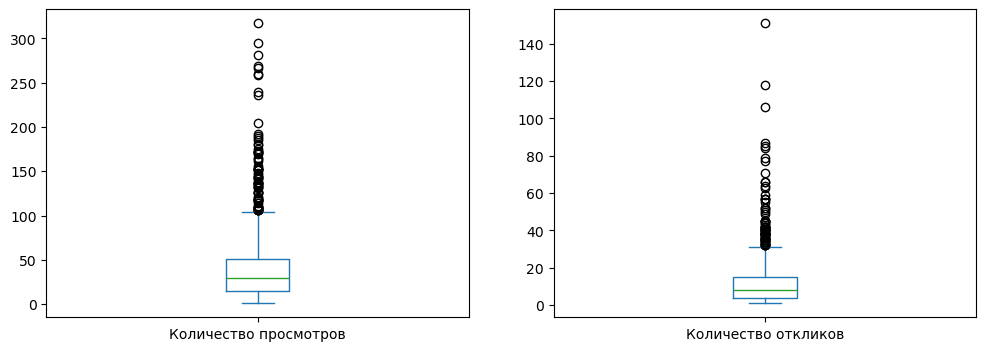

In [59]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

df['Количество просмотров'].plot(kind= 'box', ax=ax[0]);
df['Количество откликов'].plot(kind= 'box', ax=ax[1]);

In [60]:
df[['Количество просмотров', 'Количество откликов']].describe().T

,count,mean,std,min,25%,50%,75%,max
Количество просмотров,1284.0,40.193146,38.710429,1.0,15.0,30.0,51.0,317.0
Количество откликов,1284.0,11.512461,12.660222,1.0,4.0,8.0,15.0,151.0


### Вывод
Все вакансии имеют хотя бы 1 просмотр и хотя бы 1 отклик. Поэтому строить классическую воронку:

`общее кол-во вакансий -> кол-во просмотров -> кол-во откликов -> закрытие КА` не имеет смысл.




## Закрытые вакансии силами КА
Будем анализировать параметры закрытых вакансий.

In [61]:
print(f"Общее количество закрытых КА вакансий равно {df[df['Статус']=='Закрыта нами']['id'].count()}, \
что составляет {df[df['Статус']=='Закрыта нами']['id'].count()/df['id'].count():.2%} % от всех размещенных")

Общее количество закрытых КА вакансий равно 320, что составляет 24.92% % от всех размещенных


In [62]:
df_bl = df.groupby('Статус')[[ 'junior','Москва', 'СПб','Город>1', 'ИП', 'ГПХ', 'Сам-ть', 'Контракт', 'ТД', 'Удаленка', 'Офис', 'Гибрид', '<1г','>1г',\
                     'pet_pr', 'Б/О', 'другое', 'смежн',  'проф', 'Проектная', 'Частичная',  'Полная', 'Стажировка', 'Волонтерство',  'Этап тест']].mean()*100
df_bl.T

Статус,Активна,Архив,Закрыта нами,На рассмотрении,Отклонена
junior,33.823529,29.243937,30.6250,38.888889,30.476190
Москва,83.823529,76.176890,76.2500,65.555556,66.666667
СПб,13.235294,17.118402,11.8750,11.111111,17.142857
Город>1,13.235294,9.700428,5.6250,5.555556,9.523810
ИП,32.352941,48.644793,49.6875,62.222222,65.714286
ГПХ,30.882353,48.216833,47.1875,55.555556,65.714286
Сам-ть,42.647059,60.342368,69.6875,68.888889,76.190476
Контракт,38.235294,48.502140,52.8125,57.777778,60.000000
ТД,66.176471,74.465050,56.8750,74.444444,77.142857
Удаленка,67.647059,63.766049,80.3125,81.111111,68.571429


Свобдная таблица позволяет посмотреть % закрытых вакансий по параметрам и статусам. Статус "Закрыта нами" наиболее важен, т.к. позволяет оценить какое кол-во закрытых КА вакансий обладают указанными признаками.
В частности видно:
 - 76% закрытых вакансий, это вакансии с указанием города Москва. По СПБ только 12 % удалось закрыть силами КА.
 - 69% закрытых вакансий предполагают самозанятость, другие формы устройства в процентном отношении меньше, второе место это трудовой договор - 57% из закрытых вакансий предлагают этот формат занятости.
 - по формату работы  лидирут удаленка - 80% всех закрытых вакансий предлагают именно ее. ОФис и гибрид значительно меньше - 24 % и 27% соответственно.
 - по опыту работы лидируют вакансии с опытом менее года, пет-проектами  или совсем без опыта. Там, где в требованиях указан опыт более года трудоустроенных очень мало. Возможно таких вакансий вообще было мало в этой базе.
 - по образованию нет разделения. В закрытых вакансиях требовалось профильное или смежное во всех случаях. В 95% закрытых вакансиях указывалось другое.
 -  по занятости лидирует полная занятость(в 64% закрытых вакансиях). Все остальные формы (кроме волонтерства) КА закрыло в 30-31 % случаев. Волонтерство только в  13%. Но если рассматривать все статусы, то у волотерства в закрытых вакансиях именно КА % больше. 
 -  в 43% закрытых вакансий в этапах отбора предполагалось тестовое задание.

Данная таблица позволяет оценить % наличия параметров относительно всех указанных вакансий не только для тех вакансий, которые закрыло КА, но и для тех, кто имеет другие статусы: активно, архив и т.п.

Построим такую же таблицу , но с количеством вакасий по каждой категории.

In [63]:
df_bl_cnt = df.groupby('Статус')[[ 'junior','Москва', 'СПб','Город>1', 'ИП', 'ГПХ', 'Сам-ть', 'Контракт', 'ТД', 'Удаленка', 'Офис', 'Гибрид', '<1г','>1г',\
                     'pet_pr', 'Б/О', 'другое', 'смежн',  'проф', 'Проектная', 'Частичная',  'Полная', 'Стажировка', 'Волонтерство',  'Этап тест']].sum()
df_bl_cnt.T

Статус,Активна,Архив,Закрыта нами,На рассмотрении,Отклонена
junior,23,205,98,35,32
Москва,57,534,244,59,70
СПб,9,120,38,10,18
Город>1,9,68,18,5,10
ИП,22,341,159,56,69
ГПХ,21,338,151,50,69
Сам-ть,29,423,223,62,80
Контракт,26,340,169,52,63
ТД,45,522,182,67,81
Удаленка,46,447,257,73,72


Посчитаем еще количественные показатели по этим  параметрам для всех вакансий.

In [64]:
df_bl_all = df[[ 'junior','Москва', 'СПб','Город>1', 'ИП', 'ГПХ', 'Сам-ть', 'Контракт', 'ТД', 'Удаленка', 'Офис', 'Гибрид', '<1г','>1г',\
                     'pet_pr', 'Б/О', 'другое', 'смежн',  'проф', 'Проектная', 'Частичная',  'Полная', 'Стажировка', 'Волонтерство',  'Этап тест']].sum()
df_bl_all = df_bl_all.T
df_bl_all = pd.DataFrame(df_bl_all, columns=['cnt'])
df_bl_all['% от всех'] = round(df_bl_all['cnt']/df['id'].count()*100,2)
df_bl_all['cnt в закрытых КА'] = df_bl_cnt.T['Закрыта нами']
df_bl_all['% в закрытых КА'] = round(df_bl.T['Закрыта нами'],2)
df_bl_all

,cnt,% от всех,cnt в закрытых КА,% в закрытых КА
junior,393,30.61,98,30.63
Москва,964,75.08,244,76.25
СПб,195,15.19,38,11.88
Город>1,110,8.57,18,5.62
ИП,647,50.39,159,49.69
ГПХ,629,48.99,151,47.19
Сам-ть,817,63.63,223,69.69
Контракт,650,50.62,169,52.81
ТД,897,69.86,182,56.88
Удаленка,895,69.70,257,80.31


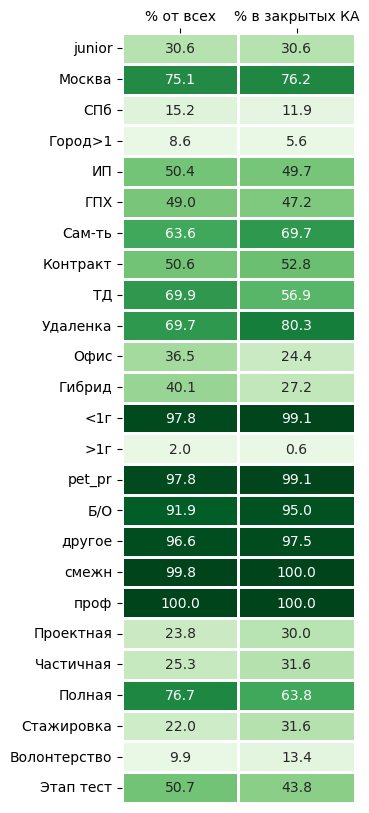

In [65]:
plt.figure(figsize=(3, 10))  
ax = sns.heatmap(df_bl_all[['% от всех','% в закрытых КА']], 
            cbar=False,  
            cmap='Greens',  
            vmin=10, 
            center=50,
            vmax=100,
            annot=True,  
            fmt='.1f',  
            linewidth=2);  
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

Тут интересно сравнение в % отношении, где у закрытых КА вакансий, этот % больше. Т.е. именно с этими параметрами наше КА закрыло больше вакансий. 
Значит для КА эти параметры встречались в закрытых вакансиях чаще. Следовательно они повышают вероятность успеха для КА.

### Рассмотрим "вклад" в успешное закрытие вакансии других параметров:
- время до закрытия вакансии (diff)
- востребованность вакансии ( % отклика)
- зарплатные ожидания
- доступность тестового задания сразу, если в этапах отбора требуется его выполнение.

####  время до закрытия вакансии (diff)

In [66]:
    df['Статус'].value_counts()

Статус
Архив              701
Закрыта нами       320
Отклонена          105
На рассмотрении     90
Активна             68
Name: count, dtype: int64

In [67]:
df.groupby('Статус').agg({'diff':['mean', 'median', 'min', 'max']})

diff                    
                      mean median   min    max
Статус                                        
Активна                NaN    NaN   NaN    NaN
Архив            49.221113   38.0   0.0  294.0
Закрыта нами     40.315625   29.0   0.0  282.0
На рассмотрении  14.000000   14.0  14.0   14.0
Отклонена        34.847619   27.0   0.0  111.0

In [68]:
df[df['Статус']=='Активна']['Дата закрытия'].unique()

<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns]

Если вакансия активна, следовательна она не закрыта и даты закрытия у нее нет. Это дополнительно проверено.
Интересна позиция `на рассмотрении` все значения - минимум, максимум, и среднее и медиана содержат одно значение 14 дней. Возможно именно столько ( 2 недели ) вакансия может быть в этом статусе. Проверим это. Таких вакансий в базе 90 шт.
Интересно сравнить статусы `архив` и `закрыта нами`. Эти 2 группы позволяют оценить качество работы агентства. Да, не все вакансии, попавшие в архив закрыты с учетом требований заказчика. Важно то, что если они попали в архив, значит наше КА не смогло их закрыть. 

In [69]:
df[df['Статус']=='На рассмотрении']['diff'].unique()

array([nan, 14.])

In [70]:
df[df['Статус']=='На рассмотрении']['diff'].value_counts()

diff
14.0    1
Name: count, dtype: int64

По указанным данным видно, что статус `на рассмотрении` имеет только 1 вакансию с датой закрытия и она как раз составляет 14 дней. Поэтому статистики так и отобразились. Все остальные 89 вакансий не имеют статуса закрытия, и следовательно время до закрытия (столбец diff) имеет пустое значение.

Рассматирвая статусы `архив` и `закрыто нами` видно, что КА закрывает вакансии быстрее (в среднем агенство за 40 дней а архив за 49, медианные значения 29 и 38 дней соотвественно).

####  востребованность вакансии ( % отклика)

In [71]:
df.groupby('Статус').agg({'% отклика':['count','mean', 'median', 'min', 'max']})

% отклика                                 
                    count       mean  median   min     max
Статус                                                    
Активна                68  30.939559  26.450  3.82  100.00
Архив                 701  33.488488  28.710  1.11  100.00
Закрыта нами          320  34.834812  31.645  1.20  100.00
На рассмотрении        90  35.756444  36.290  3.45   74.51
Отклонена             105  32.276571  30.000  1.27   75.00

In [72]:
df[df['% отклика']==100].shape[0]


21

Интересно, в базе есть 21 вакансия, у которой кол-во просмотров = кол-ву откликов. Посмотрим на эти вакансии поподробнее.
такие вакансии есть в статусе активна, и в закрытых (в том чисе и КА)


In [73]:
df[df['% отклика']==100]['Статус'].value_counts()

Статус
Архив           18
Активна          2
Закрыта нами     1
Name: count, dtype: int64

КА удалось закрыть только 1 такую вакансию. 2 еще  активны а 18 уже в архиве.

Посмотрим, какие профессии и какие требования у таких вакансий.

In [74]:
df[df['% отклика']==100]['Позиция'].unique()

array(['python-разработчик', 'менеджер проектов',
       'frontend-разработчик (react)', 'junior frontend developer',
       'младший аналитик', 'data engineer',
       'it рекрутер / менеджер по подбору персонала', 'разработчик с++',
       'junior node.js (nest) developer', 'тестировщик по / qa-инженер',
       'помощник менеджера проектов (it project manager junior)',
       'рекрутер (начинающий специалист)', 'продуктолог',
       'тестировщик (ручной)', 'qa engineer', 'project manager',
       'junior qa engineer', 'разработчик / developer с++',
       'android/ ios developer'], dtype=object)

Вакансии разные, нет выделяющихся профессий. Возможно есть временные рамки, объединяющие их?

Добавим категории, распределив отклики и просмотры по количеству:
- просмотры : <15, 15-30, 30-51, >51
- отклики: <4, 4-8, 8-15, > 15

И отдельно посмотрим на выбросы - самые популярные вакансии. 

In [75]:
df['просмотры категория'] = pd.cut(
  df['Количество просмотров'],
  bins=[0, 15, 30, 51, 400],
  labels=['<15', '15-30', '30-51', '51+']
)

In [76]:
df.insert(7,'просмотры категория',df.pop('просмотры категория'))

In [77]:
df['отклики категория'] = pd.cut(
  df['Количество откликов'],
  bins=[0, 4, 8, 15, 200],
  labels=['<4', '4-8', '8-15', '15+']
)

In [78]:
df.insert(9,'отклики категория',df.pop('отклики категория'))

In [79]:
df[df['% отклика']==100][['Дата публикации', 'Дата закрытия', 'diff', 'Количество просмотров', 'Количество откликов', 'отклики категория']]

,Дата публикации,Дата закрытия,diff,Количество просмотров,Количество откликов,отклики категория
90,2023-02-01,2023-04-03,61.0,4,4,<4
167,2023-03-03,2023-04-03,31.0,2,2,<4
260,2023-03-29,2023-04-15,17.0,2,2,<4
262,2023-03-30,2023-05-16,47.0,2,2,<4
290,2023-04-06,2023-04-07,1.0,1,1,<4
327,2023-04-13,2023-06-26,74.0,2,2,<4
489,2023-05-31,2023-07-03,33.0,1,1,<4
508,2023-06-06,2023-07-07,31.0,3,3,<4
632,2023-07-04,2023-08-15,42.0,2,2,<4
707,2023-07-21,2023-10-18,89.0,2,2,<4


По датам закономерности не выявлено. После детального рассмотрения этих вакансий интересный вывод: хоть кол-во просмотров = кол-ву откликов, их общее кол-во менее 4х. Т.е. это совершенно невостребованные вакансии. Они мало интересны канидатам. Максимальное значение параметра `% отклика` не выявило максимально привлекательные вакансии.
Посмотрим на этот параметр подробнее.

In [80]:
df.groupby(['отклики категория'],observed=True)['% отклика'].describe().T

отклики категория,<4,4-8,8-15,15+
count,404.000000,289.000000,279.000000,312.000000
mean,26.495421,30.507197,36.433011,43.743718
std,23.898304,16.621281,17.281383,16.696162
min,1.110000,3.820000,5.200000,9.140000
25%,9.520000,18.600000,23.705000,31.220000
50%,20.000000,26.320000,33.330000,42.110000
75%,33.330000,40.000000,48.140000,56.580000
max,100.000000,83.330000,90.910000,95.240000


При введении этого параметра мы предполагали, что он поможет выявить наиболее привлекательные вакансии. Но это оказалось не так. Равное или близкое кол-во просмотров и откликов не находится в категории только с максимальными просмотрами/откликами. Такие значения встречаются во всех категориях по кл-ву откликов.
Заменим значения столбца '% отклика'. В исходом виде он не интересен. Будем отмечать там только те вакансии, где категория откликов более 15 и '% отклика' > 50%. Остальные значения обнулим. Переименуем столбец, назвав его ТОП вакансии.

In [81]:
df['% отклика'] = np.where((df['% отклика']>50) & (df['отклики категория']== '15+'), 1, 0 )

In [82]:
df.rename(columns = {'% отклика':'top_vacancy'}, inplace = True )

In [83]:
df [['Количество просмотров', 'Количество откликов']].describe().T

,count,mean,std,min,25%,50%,75%,max
Количество просмотров,1284.0,40.193146,38.710429,1.0,15.0,30.0,51.0,317.0
Количество откликов,1284.0,11.512461,12.660222,1.0,4.0,8.0,15.0,151.0


In [84]:
df[df['просмотры категория'] == '51+']['Количество просмотров'].describe()

count    314.000000
mean      91.554140
std       45.481365
min       52.000000
25%       61.000000
50%       77.000000
75%      102.750000
max      317.000000
Name: Количество просмотров, dtype: float64

In [85]:
df[df['отклики категория'] == '15+']['Количество откликов'].describe()

count    312.000000
mean      27.823718
std       15.994905
min       16.000000
25%       18.000000
50%       23.000000
75%       31.000000
max      151.000000
Name: Количество откликов, dtype: float64

В данных есть 312 вакансий, у которых более 15 откликов. В 50% из них кол-во просмотров лежит в диапазоне [23-151] Посмотрим на вакансии, у которых откликов более 31 (это 25% от всех)



In [86]:
df[df['отклики категория']=='15+']['Позиция'].nunique()


177

Список значений большой. Нет возможности определить самую популярную профессию. Попробуем построить облако слов, что бы выделить ее.

In [87]:
word_cloud_1 = WordCloud(collocations = False, background_color = 'white').generate(str(df[df['отклики категория']=='15+']['Позиция'].values))
word_cloud_2 = WordCloud(collocations = False, background_color = 'white').generate(str(df[df['top_vacancy']==1]['Позиция'].values))

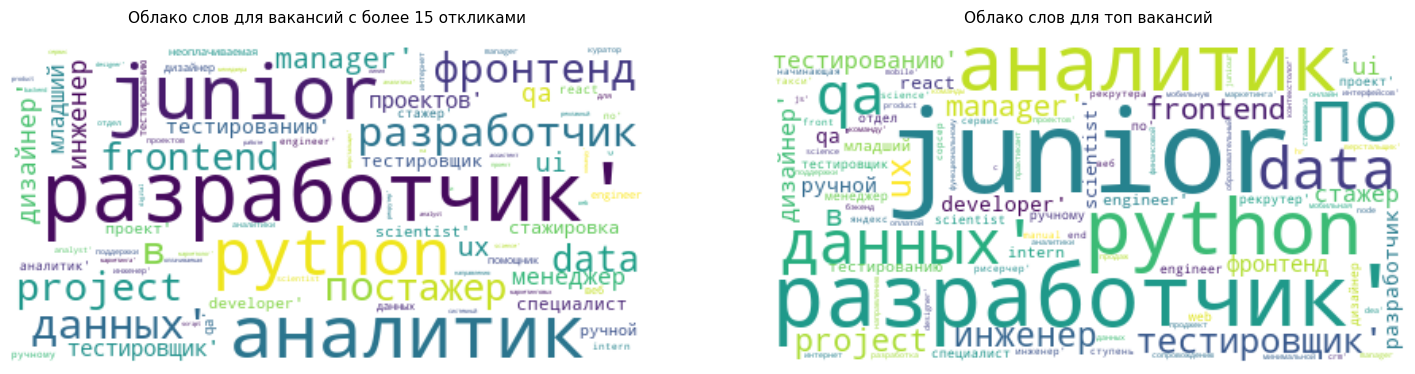

In [88]:
fig, ax = plt.subplots(1, 2);
fig.set_size_inches(18, 12);
plt.subplot(121);
plt.imshow(word_cloud_1 , interpolation='bilinear');
plt.title('Облако слов для вакансий с более 15 откликами' +"\n", fontdict={'size': 11})
plt.axis("off");
plt.subplot(122);
plt.imshow(word_cloud_2, interpolation='bilinear');
plt.title('Облако слов для топ вакансий'+"\n", fontdict={'size': 11} );
plt.axis("off");


Построенные облака слов для вакансий, у которых более 15 откликов и для вакансий, которые мо определили как ТОП (более 15 откликов и %отношения просмотров к откликам более 50%) позволяют сделать вывод, что наиболее востребованные вакансии разработчик и аналитик данных. Позиции Junior и язык программирования python в приоритете.

Посмотрим на облако слов для вакансий с минимальным кол-ом просмотров и откликов.

In [89]:
word_cloud_3 = WordCloud(collocations = False, background_color = 'white').generate(str(df[df['отклики категория']=='<4']['Позиция'].values))
word_cloud_4 = WordCloud(collocations = False, background_color = 'white').generate(str(df[df['просмотры категория']=='<15']['Позиция'].values))

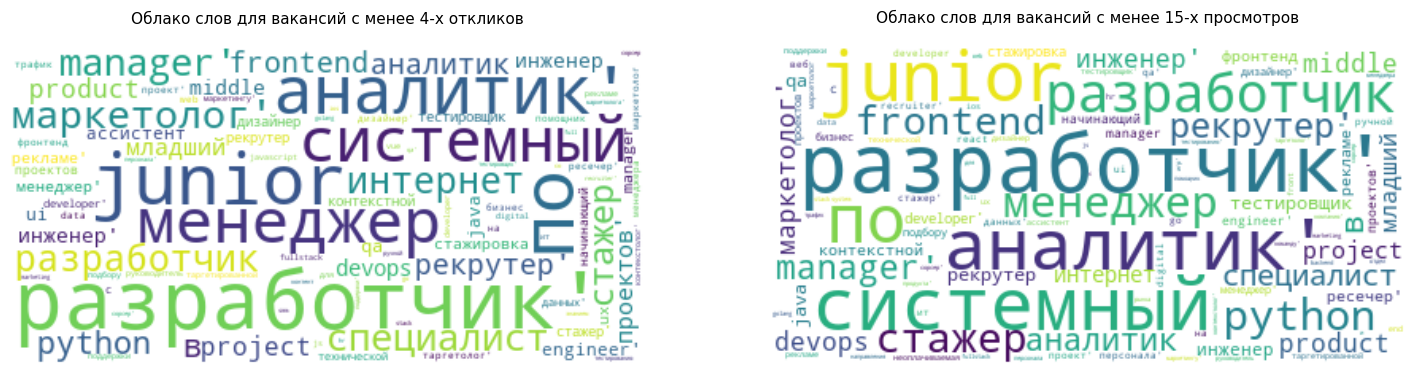

In [90]:
fig, ax = plt.subplots(1, 2);
fig.set_size_inches(18, 12);
plt.subplot(121);
plt.imshow(word_cloud_3, interpolation='bilinear');
plt.title('Облако слов для вакансий с менее 4-х откликов' +"\n", fontdict={'size': 11})
plt.axis("off");
plt.subplot(122);
plt.imshow(word_cloud_4, interpolation='bilinear');
plt.title('Облако слов для вакансий с менее 15-х просмотров'+"\n", fontdict={'size': 11} );
plt.axis("off");

Интересно, что `разработчик` и `аналитик` встречатеся тут тоже достаточно часто. Значит нельзя определенно сказать, что эти профессии относятся к востребованным. Видимо на востребованность, кроме самой профессии, у вакансии влияет какие то другие параметры. Единственное, позиция `менеджер` встречается у невостребованных вакансиях чаще. Возможно, данная БД нацелена на поиск IT специалистов в первую очередь.

#### зарплатные ожидания

In [91]:
df['зарплата'].value_counts()

зарплата
н/д       749
<50       218
50-70     122
70-100    120
100+       75
Name: count, dtype: int64

In [92]:
df_pay = df.groupby(['зарплата', 'Статус']).agg(cnt = ('зарплата','count')).reset_index()
df_pay 

,зарплата,Статус,cnt
0,100+,Активна,5
1,100+,Архив,50
2,100+,Закрыта нами,11
3,100+,Отклонена,9
4,50-70,Активна,5
5,50-70,Архив,75
6,50-70,Закрыта нами,26
7,50-70,На рассмотрении,5
8,50-70,Отклонена,11
9,70-100,Активна,12


In [93]:
df_pay_KA = df[df['Статус']=='Закрыта нами'].groupby(['зарплата', 'Статус']).agg(cnt = ('зарплата','count')).reset_index()
df_pay_KA['%cnt'] = round(df_pay_KA['cnt']/df_pay_KA['cnt'].sum()*100,2)
df_pay_KA

,зарплата,Статус,cnt,%cnt
0,100+,Закрыта нами,11,3.44
1,50-70,Закрыта нами,26,8.12
2,70-100,Закрыта нами,29,9.06
3,<50,Закрыта нами,49,15.31
4,н/д,Закрыта нами,205,64.06


In [94]:
df_pay_ar = df[df['Статус']=='Архив'].groupby(['зарплата', 'Статус']).agg(cnt = ('зарплата','count')).reset_index()
df_pay_ar['%cnt'] = round(df_pay_ar['cnt']/df_pay_ar['cnt'].sum()*100,2)
df_pay_ar

,зарплата,Статус,cnt,%cnt
0,100+,Архив,50,7.13
1,50-70,Архив,75,10.70
2,70-100,Архив,56,7.99
3,<50,Архив,137,19.54
4,н/д,Архив,383,54.64


По большинству вакансий нет данных по зарплатным ожиданиям. У КА  не указана зарплата в 64% из всех закрытых вакансий. В архивных в 54%
По тем данным что есть видно:

КА закрывали в большинстве случаев вакансии до 50 т.р, на 2ом месте категория 70-100, на 3м 50-70. Менее всего 100+

Архив : в большинстве случаев вакансии до 50 т.р, на 2ом месте категория 50-70, на 3м 70-300. Менее всего 100+

Нельзя сделать однозначного вывода, что КА или архив закрывали вакансии в разных ценовых сегментах. И там и там встречались все категории.

#### доступность тестового задания сразу, если в этапах отбора требуется его выполнение
Есть предположение, есть если в условиях требуется тестовое задание и на него сразу дается ссылка, то такая вакансия закроется быстрее. 

In [95]:
df[df['Этап тест']].groupby(['Статус', 'Ссылка на тестовое']).agg(cnt = ('Ссылка на тестовое','count'), diff_mean = ('diff','mean')\
                                                                  , diff_median = ('diff','median'), diff_min = ('diff', 'min'), diff_max = ('diff', 'max'))

cnt  diff_mean  diff_median  diff_min  \
Статус          Ссылка на тестовое                                          
Активна         да                    2        NaN          NaN       NaN   
                нет                  37        NaN          NaN       NaN   
Архив           да                   55  53.727273         45.0       2.0   
                нет                 305  47.032787         37.0       0.0   
Закрыта нами    да                   27  46.333333         32.0       8.0   
                нет                 113  46.247788         36.0       0.0   
На рассмотрении да                    8        NaN          NaN       NaN   
                нет                  48  14.000000         14.0      14.0   
Отклонена       да                    7  30.428571         29.0      14.0   
                нет                  49  36.428571         28.0       0.0   

                                    diff_max  
Статус          Ссылка на тестовое            
Активна         да                       NaN  
                нет                      NaN  
Архив           да                     168.0  
                нет                    260.0  
Закрыта нами    да                     151.0  
                нет                    164.0  
На рассмотрении да                       NaN  
                нет                     14.0  
Отклонена       да                      59.0  
                нет                    111.0

В данной таблице отражена информация по тем вакансиям, в условиях прохождения которых заявленно тестовое задание. Оцениваем время закрытия вакансии (diff  - кол-во дней от  размещения вакансии, до ее закрытия). Во всех вариантах кол-во вакансий, где ссылка присутствует сразу - меньше, чем тех, где ее сразу не выставляют.
- Для вакансий, в статусе "Активна" данных нет, т.к. нет времени закрытия.
- для вакансий в статусе на рассмотрении у большинства нет времени закрытия (выясняли это ранее, поэтому данных по diff тоже нет.
- для архивных вакансий, там где тестовое сразу выставлено, в среднем времени на закрытие требуется больше, но максимальное кол-во дней до закрытия меньше (168 против 260, когда тестового не было)
- для закрытых КА вакансий, там где тестовое сразу выставлено, в среденм данные по закрытию похожи, медианное значение даже меньше (32 для против 36). Минимальное время с тестом больше (8 дней против 0), а максимальное немного меньше у вакансий с тестовым доступным сразу (151 против 164)
- у отклоненных вакансий наличие тестового сразу не сильно влияет на медианное значение (29 против 28), максимальное значение с тестом меньше (59 против 111)


Нельзя сделать однозначный вывод, что доступность тестового задания сразу влияет на успешное закрытие вакансии.

### статус вакансии

Посмотрим, как распределялся статус вакансии во временных рамках.

Выделим месяц в датах публикации и датах закрытия вакансии.

In [96]:
df['Дата публикации месяц'] = pd.to_datetime(df['Дата публикации']).dt.strftime('%Y-%m')
df.insert(5, 'Дата публикации месяц', df.pop('Дата публикации месяц'))

In [97]:
df['Дата закрытия месяц'] = pd.to_datetime(df['Дата закрытия']).dt.strftime('%Y-%m')
df.insert(7, 'Дата закрытия месяц', df.pop('Дата закрытия месяц'))

In [98]:
df_cnt_1 = df.groupby(['Дата публикации месяц', 'Статус'])['id'].agg({'count'}).reset_index()

In [99]:
df_cnt_2 = df.groupby(['Дата закрытия месяц', 'Статус'])['id'].agg({'count'}).reset_index()

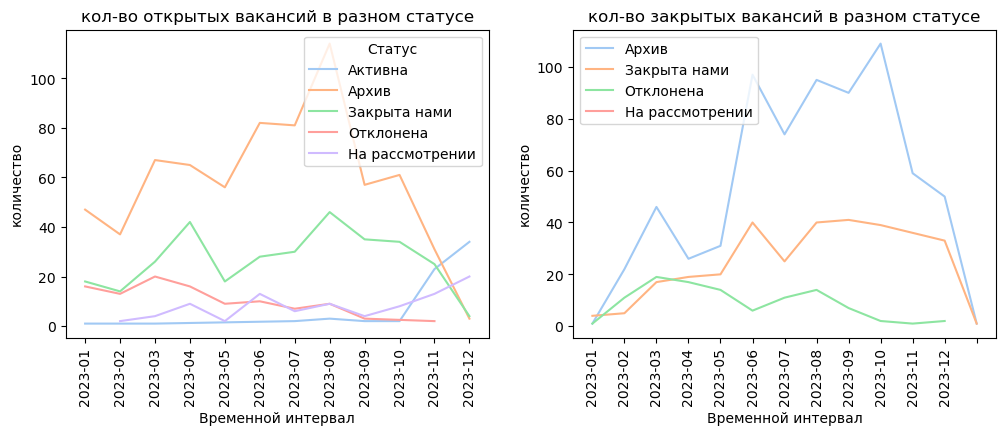

In [100]:
fig, ax = plt.subplots(1,2, figsize=(12,4))


sns.lineplot(data=df_cnt_1, x='Дата публикации месяц', y='count', hue='Статус',   palette = 'pastel',  ax=ax[0]);
ax[0].set(xlabel = 'Временной интервал', ylabel ='количество')
ax[0].set_title('кол-во открытых вакансий в разном статусе', size=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
sns.lineplot(data=df_cnt_2, x='Дата закрытия месяц', y='count', hue='Статус',  palette = 'pastel', ax=ax[1]);
ax[1].set_title('кол-во закрытых вакансий в разном статусе', size=12)
ax[1].set(xlabel = 'Временной интервал', ylabel ='количество')
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
plt.legend()
plt.show();



Кол-во вакансий, закрытых силами КА, растет в течении года. динамика роста положительная.

Вместе с тем кол-во вакансий, ушедших в архив резко возрасло с начала лета 2023 и стало снижаться в ноябре/декабре.
Причину ухода вакансии в архив определить по этим данным нельзя. Возможно летом сокращают найм специалистов вообще, поэтому вакансии уходят в архив в таком количестве.

## Степень "привлекательности" по категориям. 

Будем оценивать степень привлекательности по кол-ву просмотров и откликов. Чем интереснее вакансия для кандидата, тем больше человек на нее посмотрят.

In [101]:
df_corr_51plus = df[df['просмотры категория'] == '51+'][['Количество просмотров',  'Количество откликов', 'diff', 'top_vacancy', 'junior','Москва', 'СПб', 'Город>1', 'ИП', 'ГПХ','Сам-ть',
       'Контракт', 'ТД',  'Удаленка', 'Офис', 'Гибрид',  '<1г', '>1г', 'pet_pr', 'Б/О', 'другое', 'смежн', 'проф','Проектная', 'Частичная', 'Полная', 'Стажировка',
       'Волонтерство', 'Этап тест']]

In [102]:
df_corr_15plus = df[df['отклики категория'] == '15+'][['Количество просмотров',  'Количество откликов', 'diff', 'top_vacancy', 'junior','Москва', 'СПб', 'Город>1', 'ИП', 'ГПХ','Сам-ть',
       'Контракт', 'ТД',  'Удаленка', 'Офис', 'Гибрид',  '<1г', '>1г', 'pet_pr', 'Б/О', 'другое', 'смежн', 'проф','Проектная', 'Частичная', 'Полная', 'Стажировка',
       'Волонтерство', 'Этап тест']]

### Корреляция 
Нужны не параметрические методы корреляции, т.к. в наших данных множество столбцов с бинарным данными. 
Для них правильнее использовать Коэффициент φ (Фи). Или точечную двухрядную корреляцию для бинарных и численных данных.

Напишем функции для их вычисления и посчитаем корреляцию.

In [103]:
#Точечная двухрядная корреляция для бинарных и численных данных

# Пусть X - бинарная переменная , а Y - численная.

# M1 и M0 - средние значения переменной Y для групп X = 1 и X = 0 соответственно,
# s - среднеквадратическое отклонение переменной Y,
# N1 и N0 - количество наблюдений в группах X = 1 и X = 0 соответственно,
# N - общее количество наблюдений.

def corr_bin_num(x, y, df):
    F = df.groupby(x, group_keys=False)[y].agg(['mean','count'])
    s = df[y].std()
    N = len(df[y])
    M1 = F['mean'].iloc[1]
    M0 = F['mean'].iloc[0]
    N1 = F['count'].iloc[1]
    N0 = F['count'].iloc[0]

    r = round((M1-M0)/s*np.sqrt(N1*N0/(N*(N-1))),2)
    return r

In [104]:
# пример работы функции для просмотров
corr_bin_num('Полная', 'diff', df_corr_51plus)

-0.02

In [105]:
# пример работы функции для откликов
corr_bin_num('Полная', 'diff', df_corr_15plus)

-0.05

In [106]:
# списки числовых и булевых переменных
type_num = []
type_bool = []
for i in df_corr_51plus.columns:
    if (df_corr_51plus[i].dtypes =='int64') | (df_corr_51plus[i].dtypes =='float64'):
        type_num.append(i)
    elif df_corr_51plus[i].dtypes =='bool':
        type_bool.append(i)

In [107]:
# проверка группы с большим кол-во просмотров
for x in type_bool:
    for y in type_num:
        if df_corr_51plus[x].nunique()>1:
            if (corr_bin_num(x, y, df_corr_51plus) > 0.5 ) | (corr_bin_num(x, y, df_corr_51plus) < -0.5):
                print(f'корреляция между признаками {x} и {y} составляет {corr_bin_num(x, y, df_corr_51plus)}')
         
print('корреляция между другими признаками не выявлена')

корреляция между другими признаками не выявлена


In [108]:
# проверка группы с большим кол-во откликов

for x in type_bool:
    for y in type_num:
        if df_corr_15plus[x].nunique()>1:
            if (corr_bin_num(x, y, df_corr_15plus) > 0.5 ) | (corr_bin_num(x, y, df_corr_15plus) < -0.5):
                print(f'корреляция между признаками {x} и {y} составляет {corr_bin_num(x, y, df_corr_15plus)}')
         
print('корреляция между другими признаками не выявлена')

корреляция между другими признаками не выявлена


Значимое значение корреляции с помощью точечной двухрядной корреляции для бинарных и численных данных не обнаружено.

Напишем функцию коэффициента φ для бинарных данных. И проверим корреляцию только для бинарных данных:

- a — количество наблюдений, где обе переменные равны 1,
- b — количество наблюдений, где первая переменная равна 1, а вторая равна 0,
- c — количество наблюдений, где первая переменная равна 0, а вторая равна 1,
- d — количество наблюдений, где обе переменные равны 0.

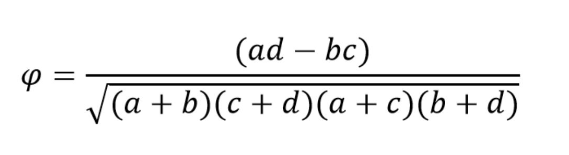

In [109]:
# df[x] и df[y] 2 бинарных столбца, между которыми мы будем искать корреляцию

def corr_phi(x, y, df):
    a = sum(df[x]*df[y])
    b = sum(df[x]>df[y])
    c = sum(df[x]<df[y])
    d = len(df[x]) - a - b -c
    phi = round((a * d - b * c) / np.sqrt((a + b) * (c + d) * (a + c) * (b + d)),2)
    return phi

In [110]:
# пример работы функции для просмотров
corr_phi('junior', 'Москва', df_corr_51plus)

-0.03

In [111]:
# пример работы функции для откликов
corr_phi('junior', 'Москва', df_corr_15plus)

0.04

In [112]:
# для просмотров
for x in type_bool:
    for y in type_bool:
        if df_corr_51plus[x].nunique()>1:
            corr_phi(x, y, df_corr_51plus)
            if ((corr_phi(x, y, df_corr_51plus) > 0.5 ) | (corr_phi(x, y, df_corr_51plus) < -0.5)) & ((x!=y) & (x>y)) :
                print(f'корреляция между признаками {x} и {y} составляет {corr_phi(x, y, df_corr_51plus)}')
print('корреляция между другими признаками не выявлена')          

корреляция между признаками СПб и Москва составляет -0.58
корреляция между признаками ИП и ГПХ составляет 0.7
корреляция между признаками Сам-ть и ИП составляет 0.66
корреляция между признаками Контракт и ИП составляет 0.56
корреляция между признаками Контракт и ГПХ составляет 0.65
корреляция между признаками Офис и Гибрид составляет 0.65
корреляция между признаками Стажировка и Волонтерство составляет 0.53
корреляция между другими признаками не выявлена


In [113]:
# для откликов
for x in type_bool:
    for y in type_bool:
        if df_corr_15plus[x].nunique()>1:
            corr_phi(x, y, df_corr_15plus)
            if ((corr_phi(x, y, df_corr_15plus) > 0.5 ) | (corr_phi(x, y, df_corr_15plus) < -0.5)) & ((x!=y) & (x>y)) :
                print(f'корреляция между признаками {x} и {y} составляет {corr_phi(x, y, df_corr_15plus)}')
print('корреляция между другими признаками не выявлена')   

корреляция между признаками ИП и ГПХ составляет 0.79
корреляция между признаками Сам-ть и ИП составляет 0.66
корреляция между признаками Контракт и ИП составляет 0.64
корреляция между признаками Контракт и ГПХ составляет 0.75
корреляция между признаками Удаленка и Офис составляет -0.58
корреляция между признаками Офис и Гибрид составляет 0.64
корреляция между признаками >1г и <1г составляет -1.0
корреляция между признаками pet_pr и <1г составляет 1.0
корреляция между признаками pet_pr и >1г составляет -1.0
корреляция между признаками Частичная и Проектная составляет 0.57
корреляция между признаками Стажировка и Волонтерство составляет 0.58
корреляция между другими признаками не выявлена


В целом оценка корреляции ничего значимого не выявила. 
Корреляция в признаках трудоустройства связанных с ИП и другими формами ( не ТД), но это логично, т.к. эти формы трудоустройства связаны. Так же связаны офис и гибрид, т.к. гибридный формат работы предполагает появление в офисе. Опыт работы более года и менее года имеет значения -1, чтологично, т.к. это противоположенные значения по смыслу.

Проверим еще значения корреляции для вакансий закрытых КА. Будем использовать точечную двухрядную корреляцию для бинарных и численных данных.

In [114]:
df_off_KA = df[df['Статус']=='Закрыта нами'][['Количество просмотров',  'Количество откликов', 'diff', 'top_vacancy', 'junior','Москва', 'СПб', 'Город>1', 'ИП', 'ГПХ','Сам-ть',
       'Контракт', 'ТД',  'Удаленка', 'Офис', 'Гибрид',  '<1г', '>1г', 'pet_pr', 'Б/О', 'другое', 'смежн', 'проф','Проектная', 'Частичная', 'Полная', 'Стажировка',
       'Волонтерство', 'Этап тест']]

In [115]:
# проверка для всех значений. Списки со столбцами идентичны

for x in type_bool:
    for y in type_num:
        if df_off_KA[x].nunique()>1:
            if (corr_bin_num(x, y, df_off_KA) > 0.5 ) | (corr_bin_num(x, y, df_off_KA) < -0.5):
                print(f'корреляция между признаками {x} и {y} составляет {corr_bin_num(x, y, df_off_KA)}')
print('корреляция между другими признаками не выявлена')
           

корреляция между другими признаками не выявлена


### Проверка статистических гипотез: 
Есть ли разница в некоторых параметрах у группы , где откликов более 15 и в тех вакансиях, где  откликов меньше?
Параметры для проверки:

- junior (вакансия в юниорской позиции)
- города: Москва, Питре, в вакансии указано более 1 города
- варианты оформления: 'ИП', 'ГПХ', 'Сам-ть', 'Контракт'
- варианты формата работы: 'Удаленка', 'Офис', 'Гибрид'
- варианты по опыту работы: '<1г', '>1г', 'pet_pr' (пет проект), 'Б/О' (без опыта)
- варианты по образованию: 'другое', 'смежн', 'проф'
- варианты по занятости:'Проектная', 'Частичная', 'Полная', 'Стажировка', 'Волонтерство'
- в условиях работы указано тестовое задание.

Во всех случаях выдвигаем нулевую гипотезу Н0, что различий нет. а альтернативную Н1, что различия в группах есть. 

Сначала проверим данные на нормальность в числовых столбцах.


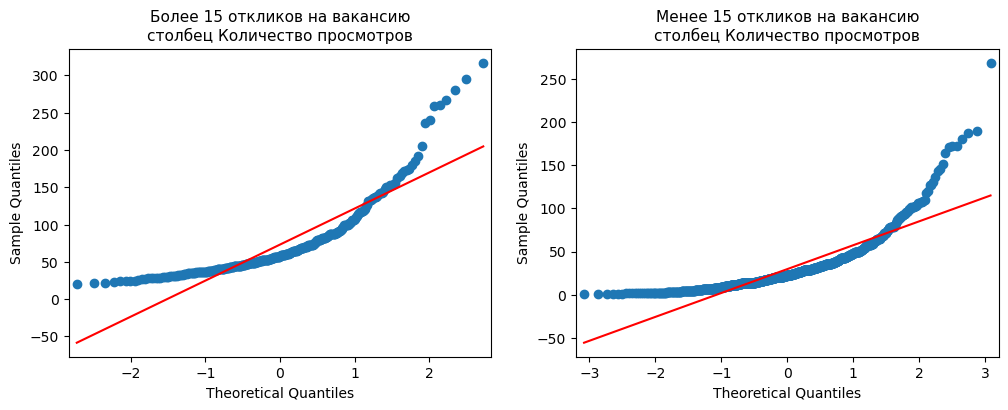

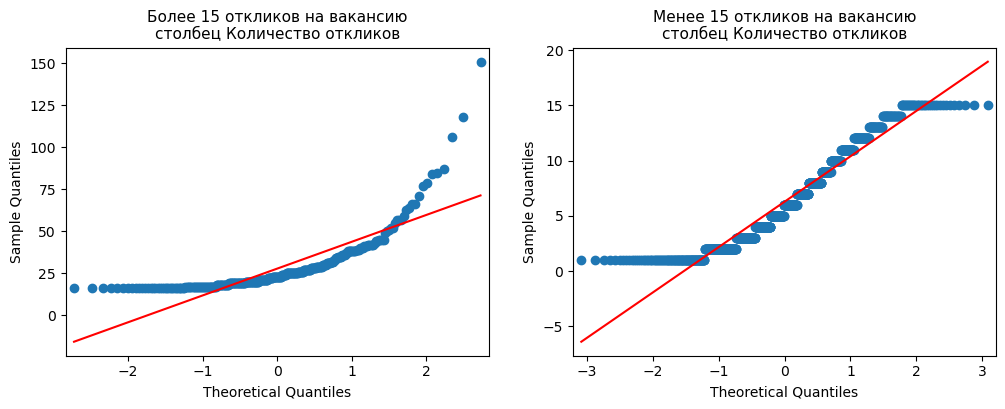

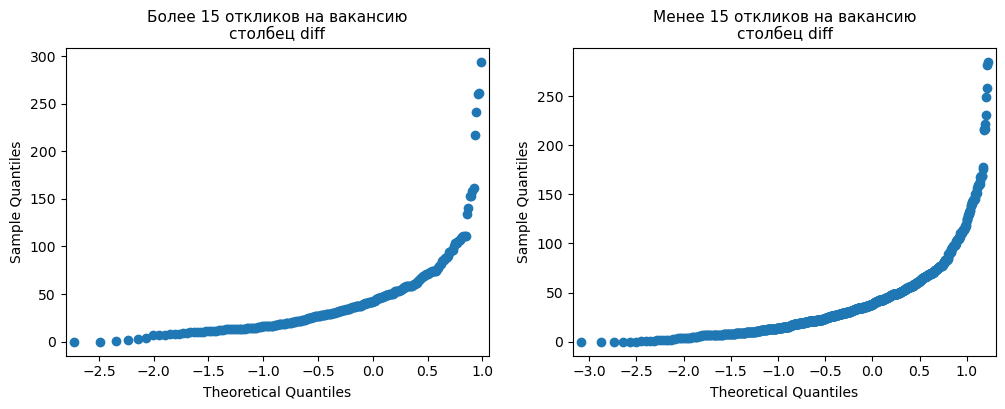

In [116]:
for col in type_num:
    resp_much=df.loc[df['отклики категория'] =='15+', col]
    resp_few=df.loc[df['отклики категория'] !='15+', col]
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    qqplot(resp_much, line='s',ax=ax[0])
    qqplot(resp_few, line='s', ax=ax[1])
    ax[0].set_title(f'Более 15 откликов на вакансию' +"\n" f'столбец {col}' , fontdict={'size': 11})

    ax[1].set_title('Менее 15 откликов на вакансию'  +"\n" f'столбец {col}', fontdict={'size': 11})
    plt.show()




Т.к. числовые данные не являются нормальными, а бинарные не являются нормальными по определению, то для проверки статистических гипотез будем использовать тест хи-квадрат Пирсона

In [117]:
columns = ['junior', 'Москва', 'СПб', 'Город>1',  'ИП', 'ГПХ', 'Сам-ть', 'Контракт', 'ТД', 'Удаленка', 'Офис', 'Гибрид', \
           '<1г', '>1г', 'pet_pr', 'Б/О',  'другое', 'смежн', 'проф', 'Проектная', 'Частичная', 'Полная', 'Стажировка','Волонтерство', 'Этап тест']

Для начала проверим одну гипотезу. Есть ли зависимость в параметре junior для вакансий в группах с разных кол-вом просмотров. Соберем общую таблицу.
H0  - различий в группах нет.
Н1  - различие в группах есть.

In [118]:
df1 = df.groupby(['отклики категория','junior'], observed=True)['отклики категория'].count()
df1 = df1.unstack()
df1

junior,False,True
отклики категория,,
<4,297,107
4-8,204,85
8-15,179,100
15+,211,101


Частоты больше 5, значит можно применять критерий хи-квадрат Пирсона

In [119]:
alpha=0.05
pvalue = chi2_contingency(df1).pvalue
if pvalue < alpha:
   print('Отвергаем нулевую гипотезу ')
else:
   print('Не получилось отвергнуть нулевую гипотезу ')

Не получилось отвергнуть нулевую гипотезу 


Мы проверяли гипотезу о независимости признаков. Критерий показал, что  гипотезу о том, что признаки независимы (различий в группе нет) мы не можем отвергнуть. То есть у нас нет оснований утверждать, что проявленный интерес к  позиции junior зависит от кол-ва откликов.

Проверим в цикле гипотезы о независимости признаков для других параметров, сразу разделив на 2 группы (менее и более 8 откликов)

In [120]:
alpha=0.05
resp_columns_H1 = []
for col in columns:
    df1 = df.groupby(['отклики категория',col], observed=True)['отклики категория'].count()
    df1 = df1.unstack()
    df1 = df1.groupby(np.arange(len(df1))//2).sum()
    pvalue = chi2_contingency(df1).pvalue
    print(f'Для параметра {col} p-value = {pvalue:.12f}')
    if pvalue < alpha:
        print('Отвергаем нулевую гипотезу ')
        resp_columns_H1.append(col)
    else:
        print('Не получилось отвергнуть нулевую гипотезу ')
    print('________________________________')


Для параметра junior p-value = 0.017197429174
Отвергаем нулевую гипотезу 
________________________________
Для параметра Москва p-value = 0.055568543767
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра СПб p-value = 0.038651481400
Отвергаем нулевую гипотезу 
________________________________
Для параметра Город>1 p-value = 0.979117066098
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра ИП p-value = 0.796618585064
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра ГПХ p-value = 0.652814428448
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра Сам-ть p-value = 0.223836394367
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра Контракт p-value = 0.454245569459
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра ТД p-value = 0.000838073228
Отвергаем нулевую г

In [121]:
print('признаки вакансий для которых нулевая гипотеза отвергнута: ' + ', '.join(resp_columns_H1))

признаки вакансий для которых нулевая гипотеза отвергнута: junior, СПб, ТД, Удаленка, Офис, Гибрид, <1г, >1г, pet_pr, Б/О, другое, Проектная, Полная, Стажировка


In [122]:
for col in resp_columns_H1:
     
    df1 = df.groupby(['отклики категория',col], observed=True)['отклики категория'].count()
    df1 = df1.unstack()
    df1 = df1.groupby(np.arange(len(df1))//2).sum()
    chi = chi2_contingency(df1).statistic
    
    # Находим общее количество измерений
    N = len(df)
    # Кол-во строк (столько различных значений принимает признак "просмотры категория")
    m = np.shape(df1)[0]
    # Кол-во столбцов (столько различных значений принимает признак)
    n = np.shape(df1)[1]
    # Считаем коэффициенты связи
    T = sqrt(chi/(N*(m-1)*(n-1)))
    K = sqrt(chi/(N*min((m-1),(n-1))))

    print(f'Для параметра {col} Коэффициент Чупрова = {T}')
    print(f'Для параметра {col} Коэффициент Крамера = {K}')
    
    print('________________________________')

Для параметра junior Коэффициент Чупрова = 0.0664879576813531
Для параметра junior Коэффициент Крамера = 0.0664879576813531
________________________________
Для параметра СПб Коэффициент Чупрова = 0.05770885199836822
Для параметра СПб Коэффициент Крамера = 0.05770885199836822
________________________________
Для параметра ТД Коэффициент Чупрова = 0.09320763442330184
Для параметра ТД Коэффициент Крамера = 0.09320763442330184
________________________________
Для параметра Удаленка Коэффициент Чупрова = 0.17868304474973157
Для параметра Удаленка Коэффициент Крамера = 0.17868304474973157
________________________________
Для параметра Офис Коэффициент Чупрова = 0.1295781002928139
Для параметра Офис Коэффициент Крамера = 0.1295781002928139
________________________________
Для параметра Гибрид Коэффициент Чупрова = 0.09419176744831281
Для параметра Гибрид Коэффициент Крамера = 0.09419176744831281
________________________________
Для параметра <1г Коэффициент Чупрова = 0.10043775437111878
Для 

In [123]:
df_resp = df.groupby(['отклики категория'], observed=True)[resp_columns_H1].sum()
df_resp = df_resp.T
df_resp['<8'] = df_resp['<4'] + df_resp['4-8']
df_resp['>8'] = df_resp['8-15'] + df_resp['15+']
df_resp['<8%'] = round(df_resp['<8']/(df_resp['<8']+df_resp['>8'])*100,2)
df_resp['>8%'] = round(df_resp['>8']/(df_resp['<8']+df_resp['>8'])*100,2)
df_resp[['<8%', '>8%']]

отклики категория,<8%,>8%
junior,48.85,51.15
СПб,61.03,38.97
ТД,57.08,42.92
Удаленка,48.04,51.96
Офис,62.61,37.39
Гибрид,59.81,40.19
<1г,53.18,46.82
>1г,92.31,7.69
pet_pr,53.18,46.82
Б/О,52.03,47.97


Проверим эти же гипотезы для ТОП вакансий. 

In [124]:
alpha=0.05
resp_pct_columns_H1 = []
for col in columns:
    df1 = df.groupby(['top_vacancy',col], observed=True)['top_vacancy'].count()
    df1 = df1.unstack()
    pvalue = chi2_contingency(df1).pvalue
    print(f'Для параметра {col} p-value = {pvalue:.12f}')
    if pvalue < alpha:
        print('Отвергаем нулевую гипотезу ')
        resp_pct_columns_H1.append(col)
    else:
        print('Не получилось отвергнуть нулевую гипотезу ')
    print('________________________________')


Для параметра junior p-value = 1.000000000000
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра Москва p-value = 0.737208799407
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра СПб p-value = 0.131311646207
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра Город>1 p-value = 1.000000000000
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра ИП p-value = 0.038898286736
Отвергаем нулевую гипотезу 
________________________________
Для параметра ГПХ p-value = 0.467226226544
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра Сам-ть p-value = 0.357712883087
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра Контракт p-value = 0.430642125472
Не получилось отвергнуть нулевую гипотезу 
________________________________
Для параметра ТД p-value = 0.080301272703
Не п

In [125]:
print('признаки вакансий для которых нулевая гипотеза отвергнута: ' + ', '.join(resp_pct_columns_H1))

признаки вакансий для которых нулевая гипотеза отвергнута: ИП, Удаленка, Офис


In [126]:
for col in resp_pct_columns_H1:
     
    df1 = df.groupby(['top_vacancy',col], observed=True)['top_vacancy'].count()
    df1 = df1.unstack()
    chi = chi2_contingency(df1).statistic
    
    # Находим общее количество измерений
    N = len(df)
    # Кол-во строк (столько различных значений принимает признак "просмотры категория")
    m = np.shape(df1)[0]
    # Кол-во столбцов (столько различных значений принимает признак)
    n = np.shape(df1)[1]
    # Считаем коэффициенты связи
    T = sqrt(chi/(N*(m-1)*(n-1)))
    K = sqrt(chi/(N*min((m-1),(n-1))))

    print(f'Для параметра {col} Коэффициент Чупрова = {T}')
    print(f'Для параметра {col} Коэффициент Крамера = {K}')
    
    print('________________________________')

Для параметра ИП Коэффициент Чупрова = 0.0576358214532877
Для параметра ИП Коэффициент Крамера = 0.0576358214532877
________________________________
Для параметра Удаленка Коэффициент Чупрова = 0.08701429332127328
Для параметра Удаленка Коэффициент Крамера = 0.08701429332127328
________________________________
Для параметра Офис Коэффициент Чупрова = 0.06172282401575336
Для параметра Офис Коэффициент Крамера = 0.06172282401575336
________________________________


Коэфициенты очень маленькие, значит связь слабая.

In [127]:
df_resp_pct = df.groupby(['top_vacancy'], observed=True)[resp_pct_columns_H1].sum()
df_resp_pct = df_resp_pct.T
df_resp_pct


top_vacancy,0,1
ИП,584,63
Удаленка,808,87
Офис,441,27


### Вывод по проверке статистических гипотез.
в данном разделе исследовалась зависимость кол-ва откликов и группы ТОП  вакансий от различных параметров вакансии (формы трудоустройства, опыта работы, образования и т.п.)

Предполагалось, что если эти параметры влияют на кол-во просмотров и откликов, то будет получена статистически значимая разница у групп. 

Далеко не все параметры показали такую разницу.

- Группы по откликам делились на 2 категории (более 8 откликов и менее). 50% процентиль равен 8
- Группы ТОП вакансий делились на 2 категрии (да или нет).

По кол-ву откликов статистически значимая разница была получена для следующих параметров:

In [128]:
print( ', '.join(resp_columns_H1))

junior, СПб, ТД, Удаленка, Офис, Гибрид, <1г, >1г, pet_pr, Б/О, другое, Проектная, Полная, Стажировка


По отнощению к топ вакансиям статистически значимая разница была получена для следующих параметров:

In [129]:
print( ', '.join(resp_pct_columns_H1))

ИП, Удаленка, Офис


Т.к. непараметрический тест  хи-квадрат Пирсона не дает ответа какой параметр больше или меньше, мы можем косвенно это понять, посмотрев на % кол-во данного признака. 
На основании этого можно предположить, что наиболее привлекательными для соискателей являются вакансии со следующими параметрами:
- удаленка
- юниорская позиция
- стажировка

## Источники лидов
Посмотрим распределение вакансий по этой позиции во временном отрезке. Так жа зависимость этой категории относительно закрытия вакансий.

In [130]:
df_cnt_5 = df.groupby(['Дата закрытия месяц', 'Источник лида'])['id'].agg({'count'}).reset_index()

In [131]:
df_cnt_6 = df[df['Статус']=='Закрыта нами'].groupby(['Дата закрытия месяц', 'Источник лида'])['id'].agg({'count'}).reset_index()

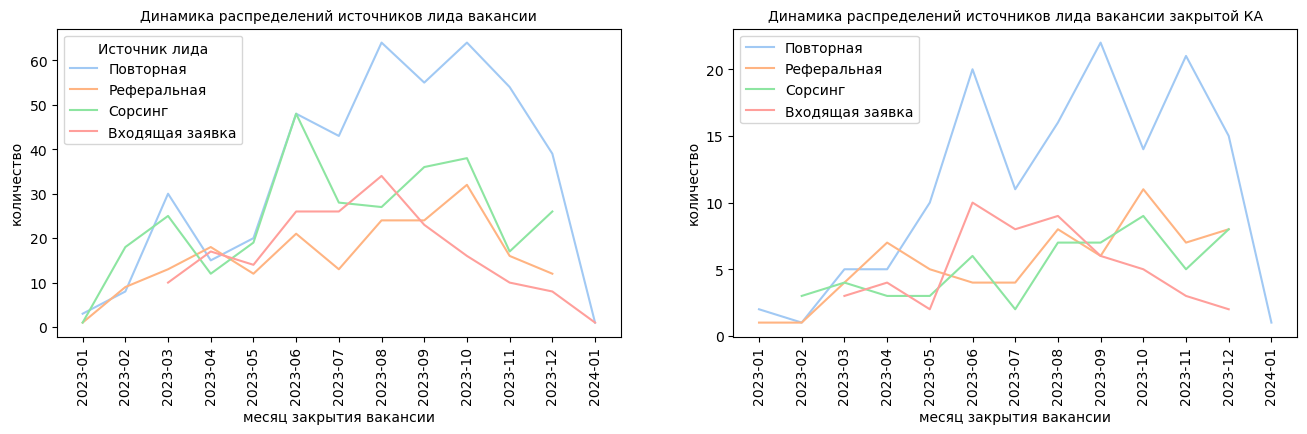

In [132]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

sns.lineplot(data=df_cnt_5, x='Дата закрытия месяц', y='count', hue='Источник лида',   palette = 'pastel', ax=ax[0]);
ax[0].set(xlabel = 'месяц закрытия вакансии', ylabel ='количество')
ax[0].set_title('Динамика распределений источников лида ваканcии', size=10)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)

sns.lineplot(data=df_cnt_6, x='Дата закрытия месяц', y='count', hue='Источник лида',   palette = 'pastel', ax=ax[1]);
ax[1].set(xlabel = 'месяц закрытия вакансии', ylabel ='количество')
ax[1].set_title('Динамика распределений источников лида вакансии закрытой КА', size=10)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
plt.legend()
plt.show();

- Январь 2024 года содержит не полные данные, его можно исключить из анализа.
- После августа 2023 года, кол-во входящих заявок пошло на спад. Однако заявки с сорсингом увеличились. Особенно это заметно в вакансиях закрытых КА.
- Так же кол-во повторных заявок возрасло во второй половине года. Для КА больше всего закрыто заявок у повторных вакансий.
- в разные месяцы кол-во закрытых вакансий разное. Динамика не плавная. Но т.к. общее кол-во вакансий не большое, это можно считать допустимой погрешностью.

## Успешность менеджеров КА

In [133]:
df.groupby('Менеджер', dropna=False).agg(cnt = ('id','count'), resp_median = ('Количество откликов', 'median'), view_median = ('Количество откликов', 'median'),\
                           diff_mean = ('diff', 'mean'), diff_median = ('diff', 'median'))\
                        .sort_values(by = ['cnt', 'resp_median'], ascending=False)

,cnt,resp_median,view_median,diff_mean,diff_median
Менеджер,,,,,
9,559,8.0,8.0,40.624242,31.0
1,227,8.0,8.0,50.803653,40.0
5,158,7.0,7.0,34.581699,30.0
7,135,7.0,7.0,56.435484,53.5
NaN,91,6.0,6.0,55.659574,42.0
3,65,15.0,15.0,60.477273,40.0
2,38,8.0,8.0,39.916667,25.5
6,9,2.0,2.0,93.333333,124.0
8,1,31.0,31.0,NaN,NaN


Посмотрим на успешность менеджеров по вакансиям закрытым КА

In [134]:
df[df['Статус']=='Закрыта нами'].groupby('Менеджер', dropna=False).agg(cnt = ('id','count'), resp_median = ('Количество откликов', 'median'), view_median = ('Количество откликов', 'median'),\
                           diff_mean = ('diff', 'mean'), diff_median = ('diff', 'median'))\
                        .sort_values(by = ['cnt', 'resp_median'], ascending=False)

,cnt,resp_median,view_median,diff_mean,diff_median
Менеджер,,,,,
9,149,11.0,11.0,42.624161,29.0
5,56,11.0,11.0,30.125000,24.5
1,54,12.0,12.0,43.277778,31.5
3,20,21.5,21.5,42.950000,32.0
7,20,10.0,10.0,41.100000,29.5
2,15,8.0,8.0,37.866667,22.0
NaN,6,9.0,9.0,46.166667,31.0


`Менеджеры 9, 5 и 1` наиболее успешны. У них больше всех вакансий, закрытых силами КА, Кол-во просмотров и откликов в среднем самое большое. 
Так же хочется отметить `менеджера 2`, у него кол-во закрытых вакансий  меньше всех (15), и по просмотрам и откликам он на последнем месте, но среднее время закрытия минимальное - 22 дня.

Посмотрим, как распределялось по времени их работа. Даты берем из даты закрытия вакансии

In [135]:
df_cnt_7 = df.groupby(['Дата закрытия месяц', 'Менеджер'], dropna=False)['id'].agg({'count'}).reset_index()
df_cnt_8 = df[df['Статус']=='Закрыта нами'].groupby(['Дата закрытия месяц', 'Менеджер'], dropna=False)['id'].agg({'count'}).reset_index()

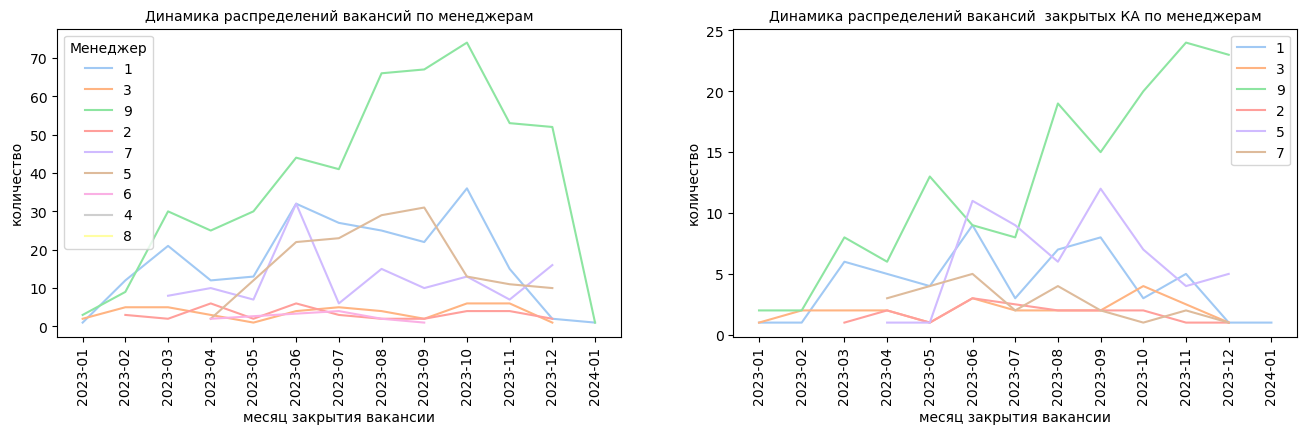

In [136]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

sns.lineplot(data=df_cnt_7, x='Дата закрытия месяц', y='count', hue='Менеджер',   palette = 'pastel', ax=ax[0]);
ax[0].set(xlabel = 'месяц закрытия вакансии', ylabel ='количество')
ax[0].set_title('Динамика распределений вакансий по менеджерам', size=10)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)

sns.lineplot(data=df_cnt_8, x='Дата закрытия месяц', y='count', hue='Менеджер',   palette = 'pastel', ax=ax[1]);
ax[1].set(xlabel = 'месяц закрытия вакансии', ylabel ='количество')
ax[1].set_title('Динамика распределений вакансий  закрытых КА по менеджерам', size=10)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
plt.legend()
plt.show();

Рассмотрев в динамике кол-во вакансий по менеджерам, можно отметить, что лидер - `менеджер 1`, в течении года увеличивал кол-во закрытых вакансий. Его работа эфективна. 
`Менеджер 5` начал свою работу в апреле, и хоть к концу года динамика снизилась, в целом осталась положительной.
`Менеджер 1` (3 место) работал полный год, но во второй пловине года кол-во вакансий у него в работе сократилось.

Посмотрим, откуда приходили вакансии для ТОП 3 менеджеров. 

In [137]:
df[df['Менеджер'].isin(['9', '1', '5'])].groupby(['Менеджер', 'Источник лида'])['id'].agg({'count'}).sort_values(by = ['Менеджер','count'] , ascending=False)

count
Менеджер Источник лида         
9        Повторная          214
         Сорсинг            177
         Реферальная        127
         Входящая заявка     40
5        Входящая заявка    107
         Повторная           33
         Реферальная         10
         Сорсинг              8
1        Повторная          120
         Сорсинг             66
         Реферальная         24
         Входящая заявка     17

Лидер - `менеджер 9`  и занимающий 3-е место `менеджер 1` больше всего работали с повторными и сорсинг заявками. А `Менеджер 5` с входящими. Это стоит отметить. Возможно, с повторными заявками работать проще.

<a name="cell-id"></a>
# Общий вывод
1. Предобработка данных не выявила явных проблем. Были сделаны необходимые преобразования. Выделены отдельные категории принадлежности вакансии (по уровню образования, опыту, городу размещения и тп)

2.  Общее количество закрытых КА вакансий равно 320, что составляет 24.92% от всех размещенных в БД
3.  Данные по вакансиям, которые закрыло КА:

- 76% всех закрытых вакансий, это вакансии с указанием города Москва. По СПБ только 12 % удалось закрыть силами КА.
- 69% всех закрытых вакансий предполагают самозанятость, другие формы устройства в процентном отношении меньше, второе место это трудовой договор - 57% из закрытых вакансий предлагают этот формат занятости.
- по формату работы  лидирут удаленка - 80% всех закрытых вакансий предлагают именно ее. ОФис и гибрид значительно меньше - 24 % и 27% соответственно. Вакансия может предлагать несколько видов трудоустройства одновременно, поэтому общий % не равен 100%.
- по опыту работы лидируют вакансии с опытом менее года, пет-проектами  или совсем без опыта. Там, где в требованиях указан опыт более года трудоустроенных очень мало. Возможно таких вакансий вообще было мало в этой базе.
- по образованию нет разделения. В закрытых вакансиях требовалось профильное или смежное во всех случаях. В 95% закрытых вакансиях указывалось другое.
- по занятости лидирует полная занятость(в 64% закрытых вакансиях). Все остальные формы (кроме волонтерства) КА закрыло в 30-31 % случаев. Волонтерство только в  13%. Но если рассматривать все статусы, то у волотерства в закрытых вакансиях именно КА % больше. 
- в 43% закрытых вакансий в этапах отбора предполагалось тестовое задание.

4. Рассматривая время закрытия вакансии (дата закрытия - дата размещения) видно, что КА закрывает вакансии быстрее (в среднем агенство за 40 дней а архив за 49, медианные значения 29 и 38 дней соотвественно).  

5. Предположение, что % отклика выявит популярные вакансии не подтвердилось. Вакансии с максимальным значением этого параметра есть (кол-во просмотров = кол-ву откликов), но их общая популярность маленькая (менее 4х откликов). Вместо этого параметра был введен парамер принадлежности к ТОП вакансиям. (отношение кол-ва откликов к кол-ву просмотров более 50% и кол-во откликов на вакансию более 15  - группа с максимальным кол-вом откликов)

6. Попытка выделения профессии, которая является наиболее востребованной не увенчалась успехом. Наиболее часто встречались позиции: разработчик и аналитик. Но они часто встречались в наименее востребованных вакансиях. Значит нельзя определенно сказать, что эти профессии относятся к востребованным. Видимо на востребованность, кроме самой профессии, у вакансии влияет какие то другие параметры. Единственное, позиция менеджер встречается у невостребованных вакансиях чаще. Возможно, данная БД нацелена на поиск IT специалистов в первую очередь.

7. По большинству вакансий нет данных по зарплатным ожиданиям. У КА не указана зарплата в 64% из всех закрытых вакансий. В архивных в 54%
По тем данным что есть видно:
- КА закрывали в большинстве случаев вакансии до 50 т.р, на 2ом месте категория 70-100, на 3м 50-70. Менее всего 100+
- Архив : в большинстве случаев вакансии до 50 т.р, на 2ом месте категория 50-70, на 3м 70-300. Менее всего 100+

Нельзя сделать однозначного вывода, что КА или архив закрывали вакансии в разных ценовых сегментах. И там и там встречались все категории.

8. Было сделано предположение, что если в этапах отбора указано тестовое задание и ссылка на него доступна сразу, это сделает вакансию более превлекательной: 
- для архивных вакансий, там где тестовое сразу выставлено, в среднем времени на закрытие требуется больше, но максимальное кол-во дней до закрытия меньше (168 против 260, когда тестового не было)
- для закрытых КА вакансий, там где тестовое сразу выставлено, в среденм данные по закрытию похожи, медианное значение даже меньше (32 для против 36). Минимальное время с тестом больше (8 дней против 0), а максимальное немного меньше у вакансий с тестовым доступным сразу (151 против 164)
- у отклоненных вакансий наличие тестового сразу не сильно влияет на медианное значение (29 против 28), максимальное значение с тестом меньше (59 против 111)

В целом нельзя сделать однозначный вывод, что это делает вакансию более привлекательной.

9. Кол-во вакансий, закрытых силами КА, растет в течении года. динамика роста положительная.

Вместе с тем кол-во вакансий, ушедших в архив резко возрасло с начала лета 2023 и стало снижаться в ноябре/декабре.
Причину ухода вакансии в архив определить по этим данным нельзя. Возможно летом сокращают найм специалистов вообще, поэтому вакансии уходят в архив в таком количестве.

10. Исследовалась зависимость кол-ва откликов и группы ТОП вакансий от различных параметров вакансии (формы трудоустройства, опыта работы, образования и т.п.)
Предполагалось, что если эти параметры влияют на кол-во откликов, то будет получена статистически значимая разница у групп более 8 откликов и менее. Так же с принадлежностью к топ вакансиям.
Для групп по кол-ву откликов статистически значимая разница полученна в следующих категориях: junior, СПб, ТД, Удаленка, Офис, Гибрид, опыт <1г, опыт >1г, наличие pet проекта, без образования, другое образование, Проектная работа, Полная занятость, Стажировка.
для групп принадлежности вакансии к ТОП в категориях: ИП, Удаленка, Офис

11. Оценка лидов вакансии по времени закрытия.
    - После августа 2023 года, кол-во входящих заявок пошло на спад. Однако заявки с сорсингом увеличились. Особенно это заметно в вакансиях закрытых КА.
    - Так же кол-во повторных заявок возрасло во второй половине года. Для КА больше всего закрыто заявок у повторных вакансий.
    - в разные месяцы кол-во закрытых вакансий разное. Динамика не плавная. Но т.к. общее кол-во вакансий не большое, это можно считать допустимой погрешностью.

12. Оценка работы менеджеров:
    - Менеджеры 9, 5 и 1 наиболее успешны. У них больше всех вакансий, закрытых силами КА, Кол-во просмотров и откликов в среднем самое большое.
    - Лидер - менеджер 9 и занимающий 3-е место менеджер 1 больше всего работали с повторными и сорсинг заявками. А Менеджер 5 с входящими. Это стоит отметить. Возможно, с повторными заявками работать проще.
    

# Рекомендации для КА
- обратить внимание на вакансии в `юниорских позициях, с полной занятостью и удаленкой`. Этот тип вакансий закрывается лучше всего. `Стажировки` тоже востребованы.
- `менеджер 9`  - самый успешный для повторных и сорсинг вакансий. Со входящими заявками хорошо работает `менеджер 5`. Следует обратить внимание на работу этих специалистов. 
